In [1]:
suppressPackageStartupMessages({
    ## This is my custom library for various helper functions for spatial pre-processing 
    # devtools::install_github('korsunskylab/spatula', dependencies = FALSE)    
    # devtools::install_github('korsunskylab/spatula')
    
    library(lme4)
    library(furrr)
    library(future)
    library(arm)    
    library(harmony)
    library(uwot)
    library(singlecellmethods)
    library(sfarrow)
    library(RANN)
    library(igraph)
    library(geojsonsf)
    library(sf)    
    library(spatula)
    library(purrr)
    library(furrr)
    library(circlize)
    library(abind)
    library(ComplexHeatmap)
    library(ggrepel)
    library(future)
    library(stringr)
    library(spatula)
    library(scales)
    library(glue)
    library(data.table)
    library(spatstat)
    library(tidyr)
    library(dplyr)
    library(data.table)
    library(presto)
    library(ggplot2)
    library(ggthemes)
    library(patchwork)
    library(Matrix)
})

fig.size <- function(h, w) {
    options(repr.plot.height = h, repr.plot.width = w)
}

# ## Clustering functions 
# source('../../ModularityClustering/R/modularity_clustering.R')
# sourceCpp('../../ModularityClustering/src/RModularityOptimizer.cpp')


source('utils_plotting.R')
source('utils.R')


# Infer gene expression

Using the Lee et al lung dataset, impute expression of all genes in the MERFISH cells. 



## Data

### Spatial

In [39]:
meta_data <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
meta_data$cell <- as.character(meta_data$cell)
counts <- spatula::readMM('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/counts.mtx')
rownames(counts) <- readLines('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/genes.txt')
colnames(counts) <- meta_data$cell
# clusters <- fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/clusters.csv')
# clusters <- map(clusters, function(x) x = factor(x, unique(as.integer(x)))) %>% bind_cols()     
# U <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U.rds')
# U2 <- readRDS('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/U2.rds')


In [40]:
i = which(meta_data$hubType == 'hybrid_hub')
meta_data = meta_data[i, ]
counts = counts[, i]


In [41]:
dim(counts)

[1]    479 140079

### single cell counts

In [37]:
counts_sc = readRDS('../data/all_ref_lee_lung.rds')@assays$RNA@counts


In [42]:
grep('CCR4', rownames(counts_sc))


[1] 3168

In [43]:
dim(counts_sc)

[1] 22500 57222

In [44]:
g = intersect(readLines('cellchat_genes.csv'), rownames(counts_sc))
counts_ref = counts_sc[g, ]

dim(counts_ref)

[1]   820 57222

In [3]:
length(readLines('cellchat_genes.csv'))

[1] 945

In [7]:
g_cellchat = readLines('cellchat_genes.csv')

g_merfish = readLines('../share/cells/genes.txt')

length(g_cellchat)
length(intersect(g_cellchat, g_merfish))


[1] 945

[1] 221

### Functions

In [47]:
impute_counts_knn = function(obj, k=5) {
    cells_spatial = obj@meta.data %>% subset(type == 'spatial') %>% rownames()
    cells_sc = obj@meta.data %>% subset(type == 'sc') %>% rownames()
    nn = nn2(
        obj@reductions$harmony@cell.embeddings[cells_sc, ],
        obj@reductions$harmony@cell.embeddings[cells_spatial, ],
        k = k
    )
    nn_mat <- Matrix::sparseMatrix(
        i = rep(seq_len(length(cells_spatial)), each = k), 
        j = c(t(nn$nn.idx)), 
        x = 1, 
        dims = c(length(cells_spatial), length(cells_sc)), 
        dimnames = list(cells_spatial, cells_sc)
    )

    counts_inferred = counts_ref[, cells_sc] %*% Matrix::t(nn_mat)
    return(counts_inferred)
}


## Stromal

### data

In [48]:
## isolate spatial cells to use
stromal_cells = fread('../data/stromal_fine_types.csv')[type_lvl2 != '']$cell
cells = meta_data[hubType == 'hybrid_hub' & cell %in% stromal_cells, cell]


In [49]:
ref = readRDS('../data/stromal_ref_lee_lung.rds')
ref_markers = fread('../data/stromal_ref_lee_lung_markers.csv')
genes_ref = ref_markers[pvalue < .05 & logFC > 0][, unique(feature)]  
length(genes_ref)


[1] 174

### harmonize

In [50]:
obj <- Seurat::CreateSeuratObject(
    counts = Matrix::cbind2(
        counts[genes_ref, cells],
        counts_sc[genes_ref, rownames(ref@meta.data)]
    ),
    meta.data = bind_rows(
        # spatial = dplyr::select(spa@meta.data, batch=library, type_lvl2), 
        spatial = meta_data[match(cells, meta_data$cell), ] %>% 
            data.frame() %>% 
            tibble::column_to_rownames('cell') %>% 
            dplyr::select(batch=library, type_lvl2),
        sc = dplyr::select(ref@meta.data, batch=Sample, seurat_clusters), 
        .id = 'type'
    ) %>% 
        dplyr::select(type, batch, everything()) %>% 
        data.frame()
)

# ## drop levels
# obj@meta.data$orig.ident <- as.character(obj@meta.data$orig.ident)


In [51]:
# obj@meta.data %>% filter(type != 'spatial')

In [52]:
dim(obj)

[1]   174 21296

In [53]:
table(obj@meta.data$type)
table(is.na(obj@meta.data$type))



     sc spatial 
   2147   19149 


FALSE 
21296 

In [54]:
norm_factor = data.table(obj@meta.data)[, median(nCount_RNA), by = type][, median(V1)]
norm_factor

[1] 165.5

Warning message:
“The following arguments are not used: nselect”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



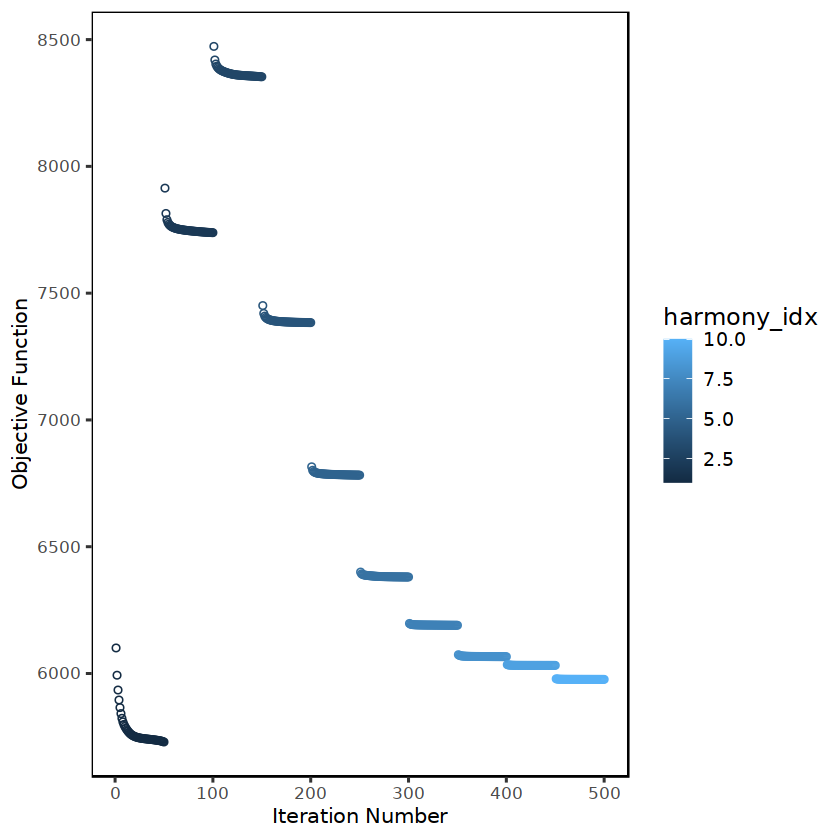

In [55]:
obj <- obj %>% 
    Seurat::NormalizeData(scale.factor = norm_factor) %>% 
    Seurat::FindVariableFeatures() %>% 
    RunBalancedPCA(weight.by = 'type') %>% 
    RunHarmony(
        c('type', 'batch'), 
        plot_convergence = TRUE,
        max.iter.harmony = 10, max.iter.cluster = 50,
        sigma = .15, 
        ## Try running harmony with low thetas first 
        theta = c(1, 0),
        
        ## For safety, avoid harmony stopping early 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf,
        
        ## Protect against overintegrating small batches
        # tau = 5,
        
        ## This fails for some reason on the Seurat side 
        project.dim = FALSE
    ) %>% 
    identity()


In [57]:
library(Seurat)

In [58]:
system.time({
    U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.3, spread = 1.0, ret_extra = 'fgraph', fast_sgd = TRUE, n_sgd_threads = 60)     
    # U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 60)     
})

colnames(U$embedding) <- c('HUMAP1', 'HUMAP2')

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



   user  system elapsed 
 24.331   0.329   6.789 

In [59]:
rownames(U$fgraph) <- colnames(U$fgraph) <- Cells(obj)

obj[['humap']] <- Seurat::CreateDimReducObject(
    embeddings = U$embedding,
    assay = 'RNA', 
    key = 'HUMAP_', 
    global = TRUE
)
new_graph <- Seurat::as.Graph(U$fgraph)
DefaultAssay(new_graph) <- DefaultAssay(obj)
obj[['humap_fgraph']] <- new_graph

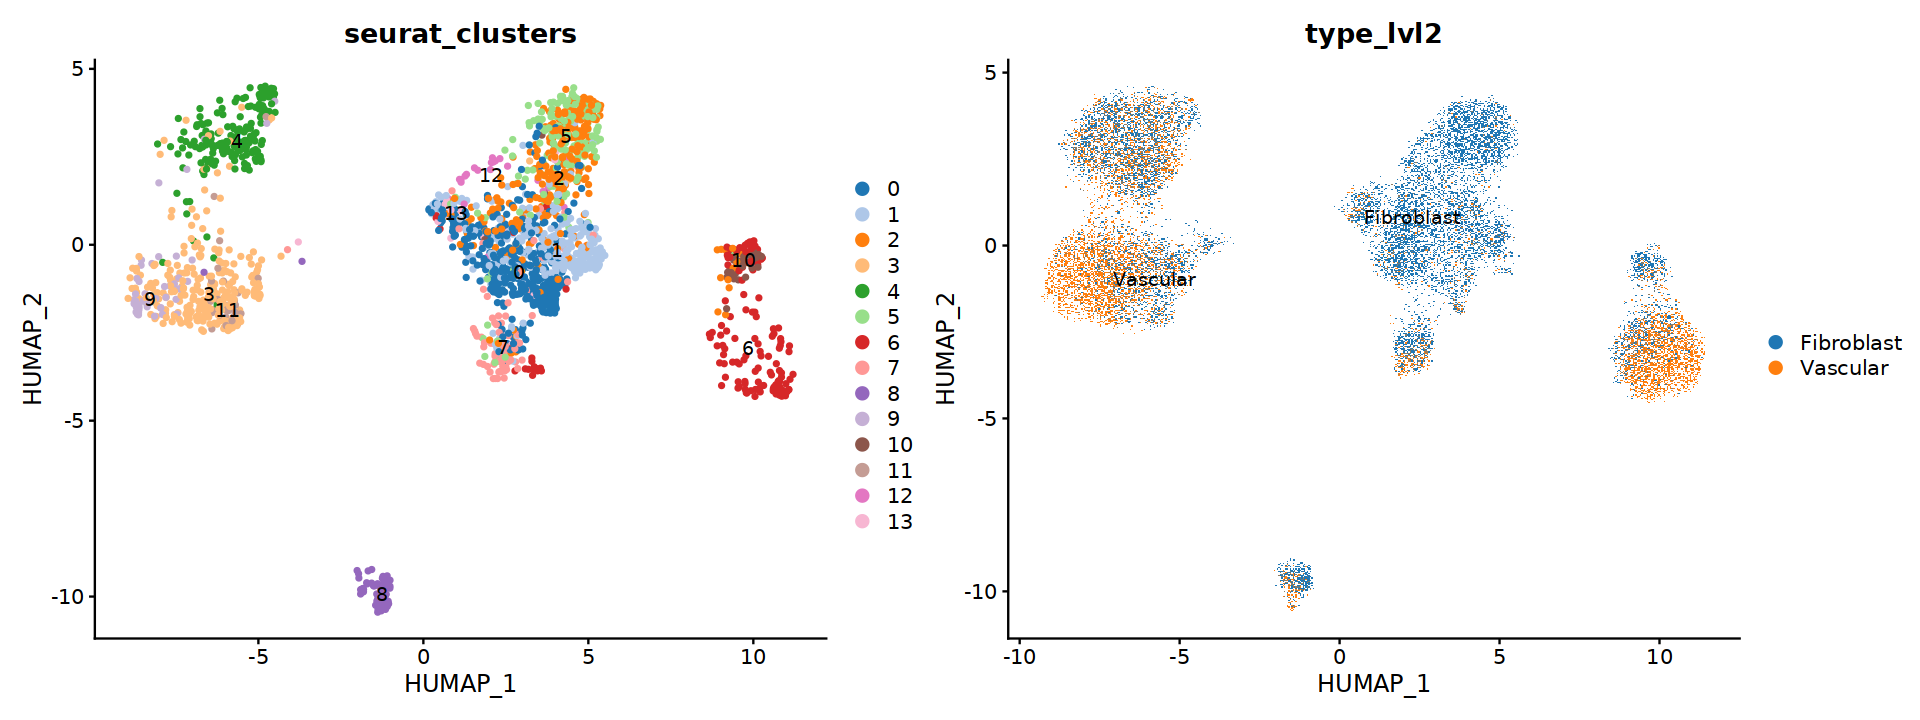

In [60]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'type_lvl2', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 10') 


### Infer counts

In [61]:
system.time({
    counts_imputed = impute_counts_knn(obj, k=5)    
})


   user  system elapsed 
  2.904   0.009   2.917 

In [62]:
counts_imputed[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
      2629 2634 2661 2663 2673
TGFB1    .    1    2    1    2
TGFB2    .    .    .    .    .
TGFB3    3    1    4    4    .
BMP2     .    .    1    .    1
BMP4     .    4    3    1    1

### Cache

In [63]:
spatula::writeMM(counts_imputed, '../data/counts_inferred_stromal.mtx')
writeLines(colnames(counts_imputed), '../data/counts_inferred_stromal_colnames.txt')
writeLines(rownames(counts_imputed), '../data/counts_inferred_stromal_rownames.txt')


## TNK

### data

In [66]:
cells = meta_data %>% 
    filter(type_lvl1 == 'Lymphocyte') %>% 
    filter(type_lvl2 != 'B') %>% 
    with(cell)

In [67]:
# ref = readRDS('../data/tnk_ref_lee_lung.rds')
ref_meta = fread('../data/tnk_ref_lee_lung_meta.csv')
ref_markers = fread('../data/tnk_ref_lee_lung_markers.csv')
genes_ref = ref_markers[pvalue < .05 & logFC > 0][, unique(feature)]  
length(genes_ref)

[1] 256

### harmonize

In [68]:
obj <- Seurat::CreateSeuratObject(
    counts = Matrix::cbind2(
        counts[genes_ref, cells],
        counts_sc[genes_ref, ref_meta$cellid]
    ),
    meta.data = bind_rows(
        spatial = meta_data[match(cells, meta_data$cell), ] %>% 
            data.frame() %>% 
            tibble::column_to_rownames('cell') %>% 
            dplyr::select(batch=library, type_lvl2),
        sc = dplyr::select(tibble::column_to_rownames(data.frame(ref_meta), 'cellid'), batch=Sample, seurat_clusters), 
        .id = 'type'
    ) %>% 
        dplyr::select(type, batch, everything()) %>% 
        data.frame()
)


In [69]:
# obj@meta.data %>% filter(type != 'spatial')

In [70]:
dim(obj)

[1]   256 55561

In [71]:
table(obj@meta.data$type)
table(is.na(obj@meta.data$type))



     sc spatial 
  15808   39753 


FALSE 
55561 

In [72]:
norm_factor = data.table(obj@meta.data)[, median(nCount_RNA), by = type][, median(V1)]
norm_factor

[1] 70.5

Warning message:
“The following arguments are not used: nselect”
Warning message:
“did not converge in 25 iterations”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



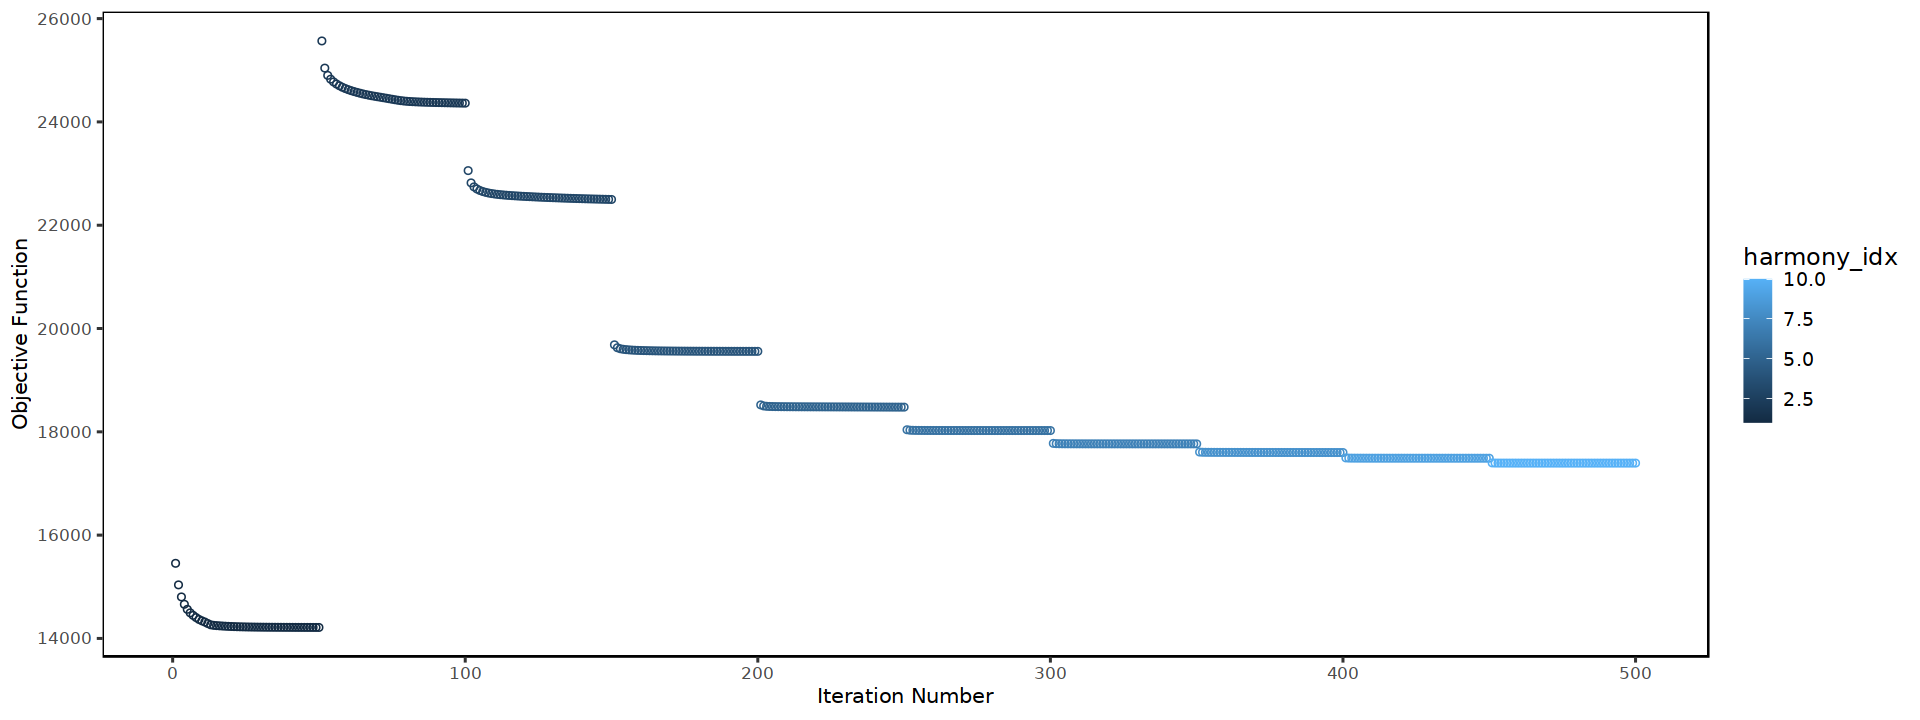

In [73]:
obj <- obj %>% 
    Seurat::NormalizeData(scale.factor = norm_factor) %>% 
    Seurat::FindVariableFeatures() %>% 
    RunBalancedPCA(weight.by = 'type') %>% 
    RunHarmony(
        c('type', 'batch'), 
        plot_convergence = TRUE,
        max.iter.harmony = 10, max.iter.cluster = 50,
        sigma = .15, 
        ## Try running harmony with low thetas first 
        theta = c(1, 0),
        
        ## For safety, avoid harmony stopping early 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf,
        
        ## Protect against overintegrating small batches
        # tau = 5,
        
        ## This fails for some reason on the Seurat side 
        project.dim = FALSE
    ) %>% 
    identity()


In [74]:
library(Seurat)

In [75]:
system.time({
    U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.3, spread = 1.0, ret_extra = 'fgraph', fast_sgd = TRUE, n_sgd_threads = 60)     
    # U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 60)     
})

colnames(U$embedding) <- c('HUMAP1', 'HUMAP2')

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



   user  system elapsed 
 58.772   0.503  12.612 

In [76]:
rownames(U$fgraph) <- colnames(U$fgraph) <- Cells(obj)

obj[['humap']] <- Seurat::CreateDimReducObject(
    embeddings = U$embedding,
    assay = 'RNA', 
    key = 'HUMAP_', 
    global = TRUE
)
new_graph <- Seurat::as.Graph(U$fgraph)
DefaultAssay(new_graph) <- DefaultAssay(obj)
obj[['humap_fgraph']] <- new_graph

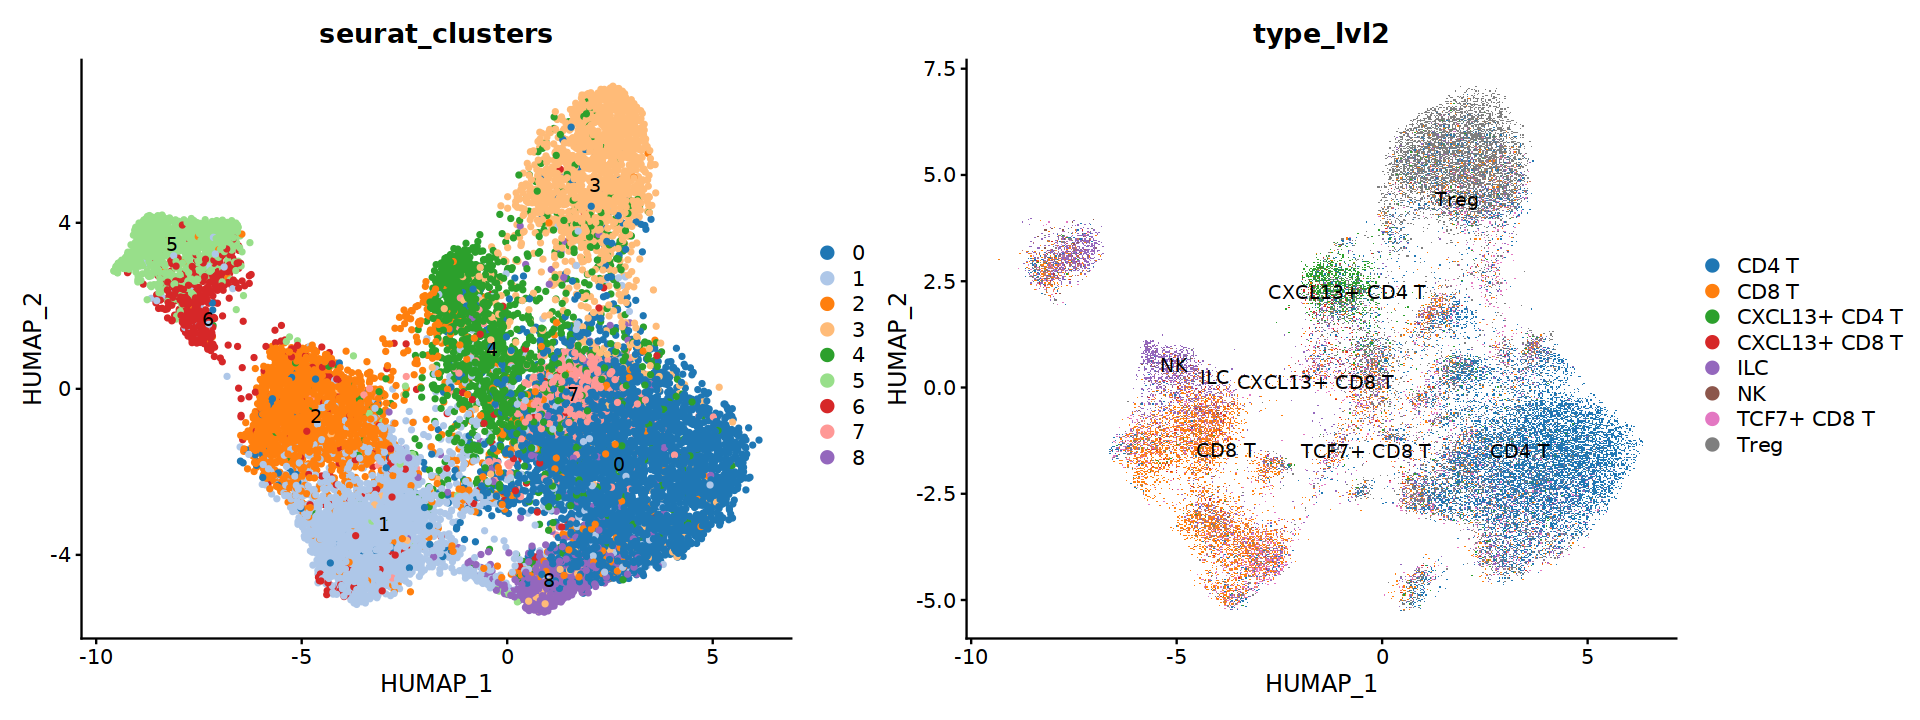

In [77]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'type_lvl2', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 10') 


### Infer counts

In [78]:
system.time({
    counts_imputed = impute_counts_knn(obj, k=5)    
})


   user  system elapsed 
 35.778   0.076  35.846 

In [79]:
counts_imputed[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
      2631 2633 2717 2723 2724
TGFB1    1    3    3    1    1
TGFB2    .    .    .    .    .
TGFB3    .    .    .    .    .
BMP2     .    .    .    .    .
BMP4     .    .    .    .    .

### Cache

In [80]:
spatula::writeMM(counts_imputed, '../data/counts_inferred_tnk.mtx')
writeLines(colnames(counts_imputed), '../data/counts_inferred_tnk_colnames.txt')
writeLines(rownames(counts_imputed), '../data/counts_inferred_tnk_rownames.txt')


## Myeloid

### data

In [81]:
table(meta_data$type_lvl1)


           Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma 
     15013      14420      13306      44414       1010      31999      11499 
  Vascular 
      8418 

In [82]:
cells = meta_data %>% 
    filter(type_lvl1 == 'Myeloid') %>% 
    # filter(type_lvl2 != 'B') %>% 
    with(cell)

In [83]:
# ref = readRDS('../data/tnk_ref_lee_lung.rds')
ref_meta = fread('../data/myeloid_ref_lee_lung_meta.csv')
ref_markers = fread('../data/myeloid_ref_lee_lung_markers.csv')
genes_ref = ref_markers[pvalue < .05 & logFC > 0][, unique(feature)]  
nrow(ref_meta)
length(genes_ref)


[1] 9293

[1] 331

### harmonize

In [84]:
obj <- Seurat::CreateSeuratObject(
    counts = Matrix::cbind2(
        counts[genes_ref, cells],
        counts_sc[genes_ref, ref_meta$cellid]
    ),
    meta.data = bind_rows(
        spatial = meta_data[match(cells, meta_data$cell), ] %>% 
            data.frame() %>% 
            tibble::column_to_rownames('cell') %>% 
            dplyr::select(batch=library, type_lvl2),
        sc = dplyr::select(tibble::column_to_rownames(data.frame(ref_meta), 'cellid'), batch=Sample, seurat_clusters), 
        .id = 'type'
    ) %>% 
        dplyr::select(type, batch, everything()) %>% 
        data.frame()
)


In [85]:
dim(obj)

[1]   331 41292

In [86]:
table(obj@meta.data$type)
table(is.na(obj@meta.data$type))



     sc spatial 
   9293   31999 


FALSE 
41292 

In [87]:
norm_factor = data.table(obj@meta.data)[, median(nCount_RNA), by = type][, median(V1)]
norm_factor

[1] 387.5

Warning message:
“The following arguments are not used: nselect”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2064600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2064600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2064600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 2064600)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



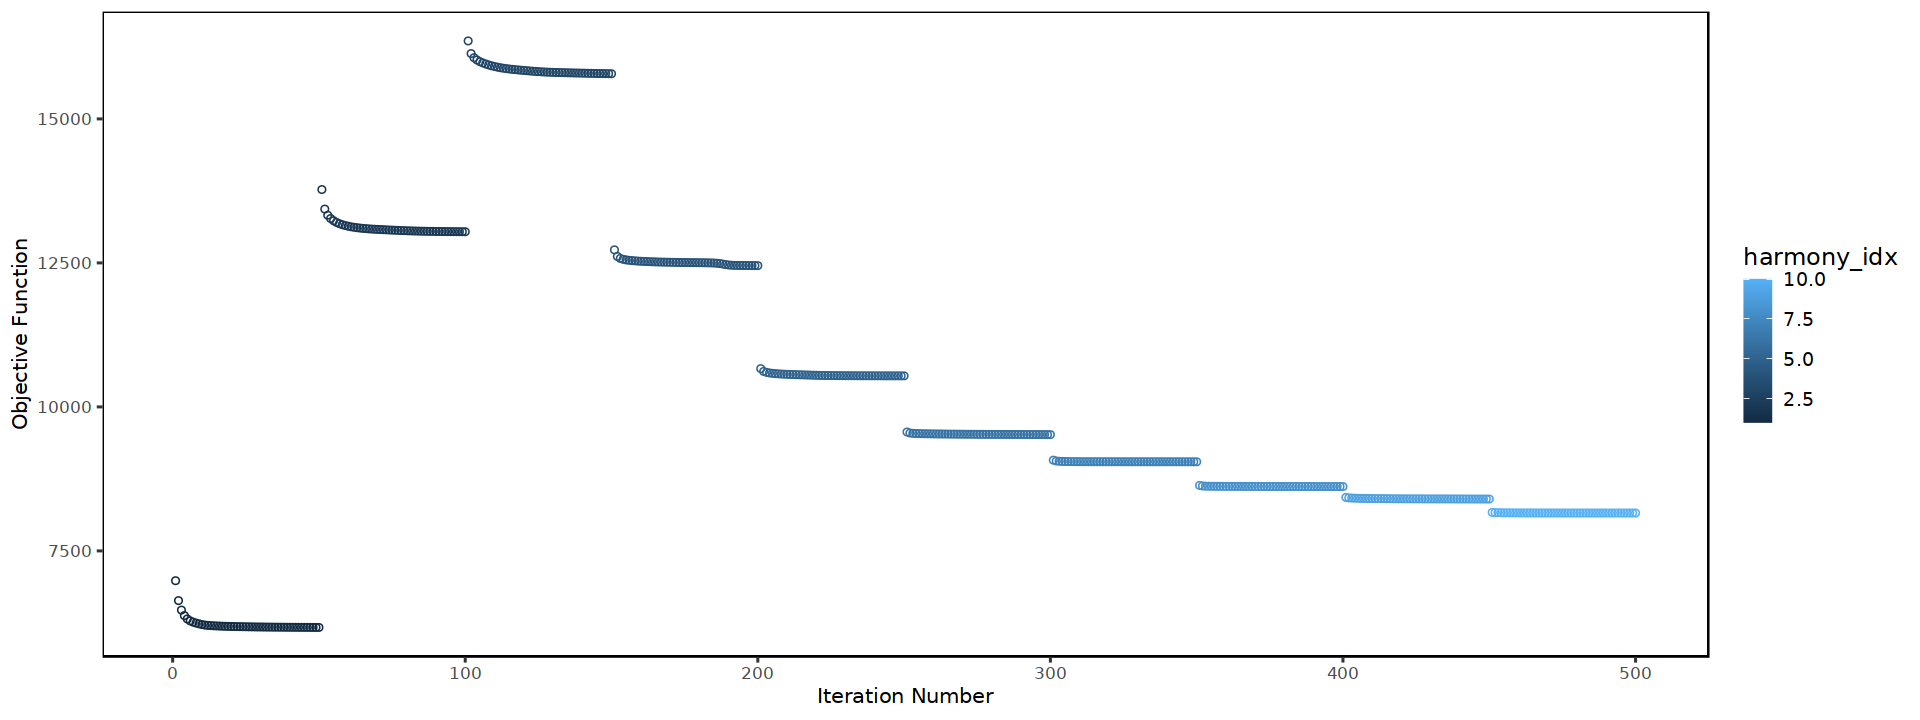

In [88]:
obj <- obj %>% 
    Seurat::NormalizeData(scale.factor = norm_factor) %>% 
    Seurat::FindVariableFeatures() %>% 
    RunBalancedPCA(weight.by = 'type') %>% 
    RunHarmony(
        c('type', 'batch'), 
        plot_convergence = TRUE,
        max.iter.harmony = 10, max.iter.cluster = 50,
        sigma = .15, 
        ## Try running harmony with low thetas first 
        theta = c(1, 0),
        
        ## For safety, avoid harmony stopping early 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf,
        
        ## Protect against overintegrating small batches
        # tau = 5,
        
        ## This fails for some reason on the Seurat side 
        project.dim = FALSE
    ) %>% 
    identity()


In [89]:
library(Seurat)

In [90]:
system.time({
    U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.3, spread = 1.0, ret_extra = 'fgraph', fast_sgd = TRUE, n_sgd_threads = 60)     
    # U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 60)     
})

colnames(U$embedding) <- c('HUMAP1', 'HUMAP2')

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



   user  system elapsed 
 43.884   0.420   9.700 

In [91]:
rownames(U$fgraph) <- colnames(U$fgraph) <- Cells(obj)

obj[['humap']] <- Seurat::CreateDimReducObject(
    embeddings = U$embedding,
    assay = 'RNA', 
    key = 'HUMAP_', 
    global = TRUE
)
new_graph <- Seurat::as.Graph(U$fgraph)
DefaultAssay(new_graph) <- DefaultAssay(obj)
obj[['humap_fgraph']] <- new_graph

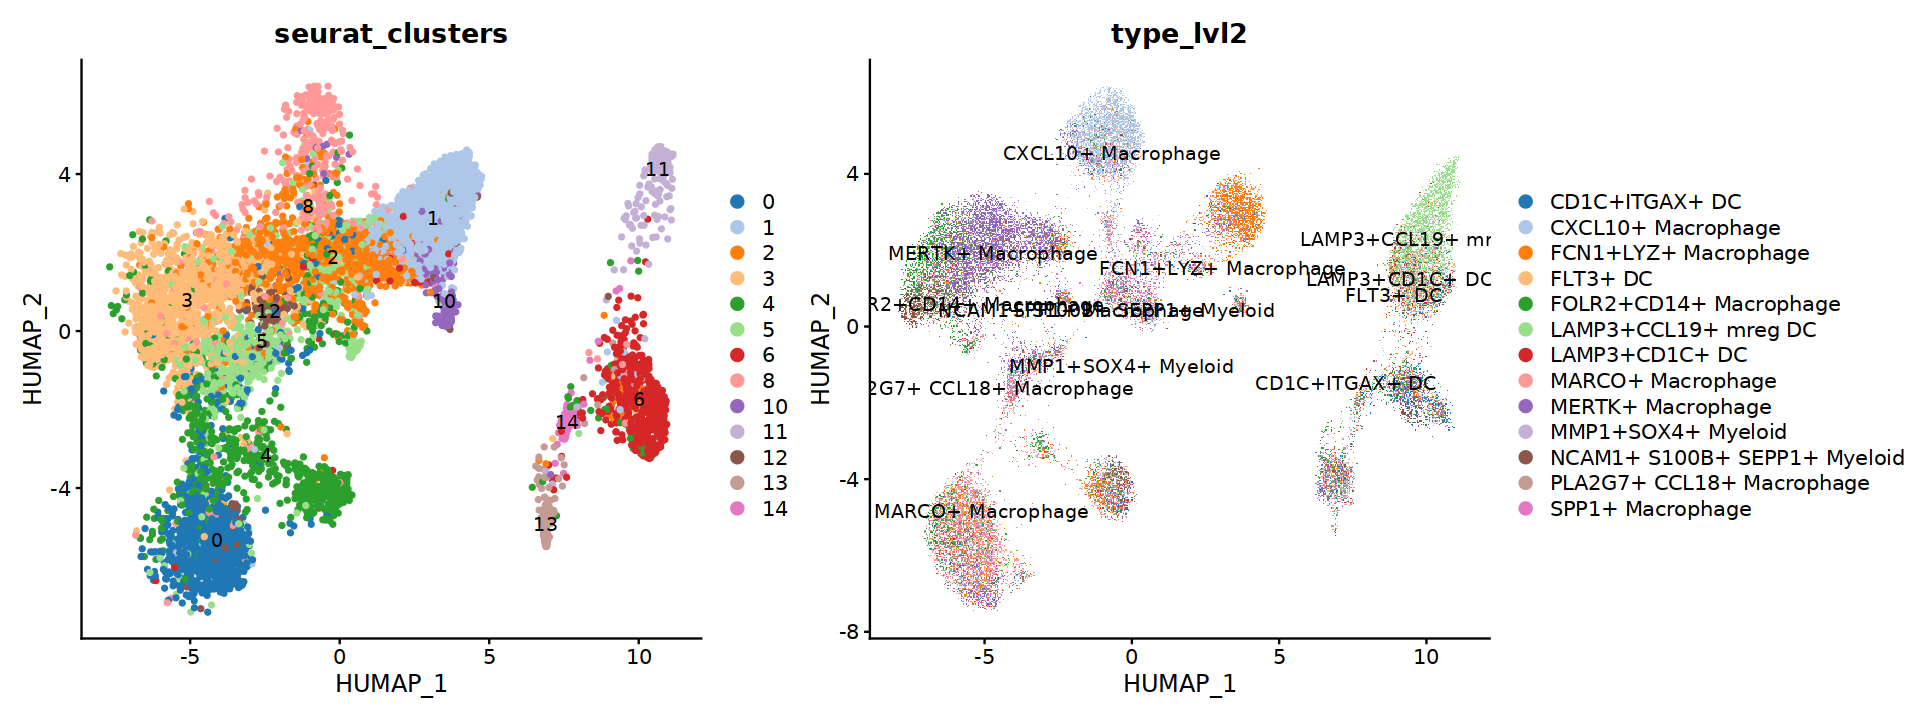

In [92]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'type_lvl2', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 20') 


### Infer counts

In [93]:
system.time({
    counts_imputed = impute_counts_knn(obj, k=5)    
})


   user  system elapsed 
 15.721   0.081  15.798 

In [94]:
counts_imputed[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
      2669 2699 2728 2739 2768
TGFB1    1    4    .    1    3
TGFB2    .    .    .    .    .
TGFB3    .    .    .    .    .
BMP2     .    .    .    .    .
BMP4     .    .    .    .    .

### Cache

In [95]:
spatula::writeMM(counts_imputed, '../data/counts_inferred_myeloid.mtx')
writeLines(colnames(counts_imputed), '../data/counts_inferred_myeloid_colnames.txt')
writeLines(rownames(counts_imputed), '../data/counts_inferred_myeloid_rownames.txt')


## Mast

### data

In [96]:
table(meta_data$type_lvl1)


           Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma 
     15013      14420      13306      44414       1010      31999      11499 
  Vascular 
      8418 

In [97]:
cells = meta_data %>% 
    filter(type_lvl1 == 'Mast') %>% 
    with(cell)


In [98]:
table(meta_data[cell %in% cells]$type_lvl1)
table(meta_data[cell %in% cells]$type_lvl2)



Mast 
1010 


Mast 
1010 

In [99]:
# ref = readRDS('../data/tnk_ref_lee_lung.rds')
ref_meta = fread('../data/mast_ref_lee_lung_meta.csv')
ref_markers = fread('../data/mast_ref_lee_lung_markers.csv')
genes_ref = ref_markers[pvalue < .05 & logFC > 0][, unique(feature)]  
nrow(ref_meta)
length(genes_ref)


[1] 1755

[1] 86

### harmonize

In [100]:
obj <- Seurat::CreateSeuratObject(
    counts = Matrix::cbind2(
        counts[genes_ref, cells],
        counts_sc[genes_ref, ref_meta$cellid]
    ),
    meta.data = bind_rows(
        spatial = meta_data[match(cells, meta_data$cell), ] %>% 
            data.frame() %>% 
            tibble::column_to_rownames('cell') %>% 
            dplyr::select(batch=library, type_lvl2),
        sc = dplyr::select(tibble::column_to_rownames(data.frame(ref_meta), 'cellid'), batch=Sample, seurat_clusters), 
        .id = 'type'
    ) %>% 
        dplyr::select(type, batch, everything()) %>% 
        data.frame()
)


In [101]:
dim(obj)

[1]   86 2765

In [102]:
table(obj@meta.data$type)
table(is.na(obj@meta.data$type))



     sc spatial 
   1755    1010 


FALSE 
 2765 

In [103]:
norm_factor = data.table(obj@meta.data)[, median(nCount_RNA), by = type][, median(V1)]
norm_factor

[1] 50

Warning message:
“The following arguments are not used: nselect”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



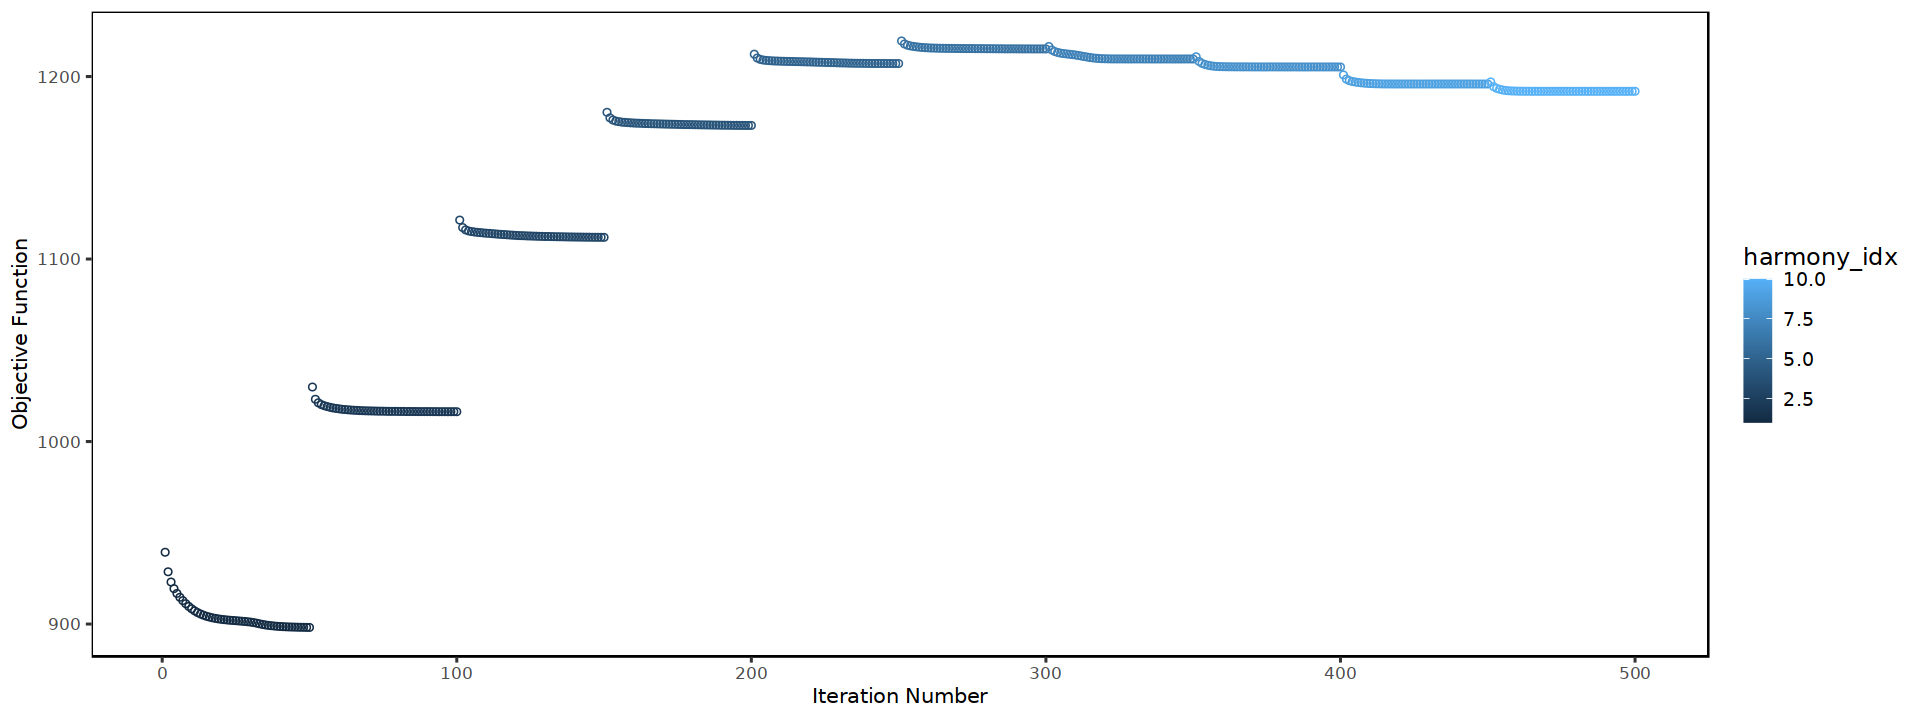

In [104]:
obj <- obj %>% 
    Seurat::NormalizeData(scale.factor = norm_factor) %>% 
    Seurat::FindVariableFeatures() %>% 
    RunBalancedPCA(weight.by = 'type') %>% 
    RunHarmony(
        c('type', 'batch'), 
        plot_convergence = TRUE,
        max.iter.harmony = 10, max.iter.cluster = 50,
        sigma = .15, 
        ## Try running harmony with low thetas first 
        theta = c(1, 0),
        
        ## For safety, avoid harmony stopping early 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf,
        
        ## Protect against overintegrating small batches
        # tau = 5,
        
        ## This fails for some reason on the Seurat side 
        project.dim = FALSE
    ) %>% 
    identity()


In [105]:
library(Seurat)

In [106]:
system.time({
    U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.3, spread = 1.0, ret_extra = 'fgraph', fast_sgd = TRUE, n_sgd_threads = 60)     
    # U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 60)     
})

colnames(U$embedding) <- c('HUMAP1', 'HUMAP2')

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



   user  system elapsed 
  9.729   0.605   3.991 

In [107]:
rownames(U$fgraph) <- colnames(U$fgraph) <- Cells(obj)

obj[['humap']] <- Seurat::CreateDimReducObject(
    embeddings = U$embedding,
    assay = 'RNA', 
    key = 'HUMAP_', 
    global = TRUE
)
new_graph <- Seurat::as.Graph(U$fgraph)
DefaultAssay(new_graph) <- DefaultAssay(obj)
obj[['humap_fgraph']] <- new_graph

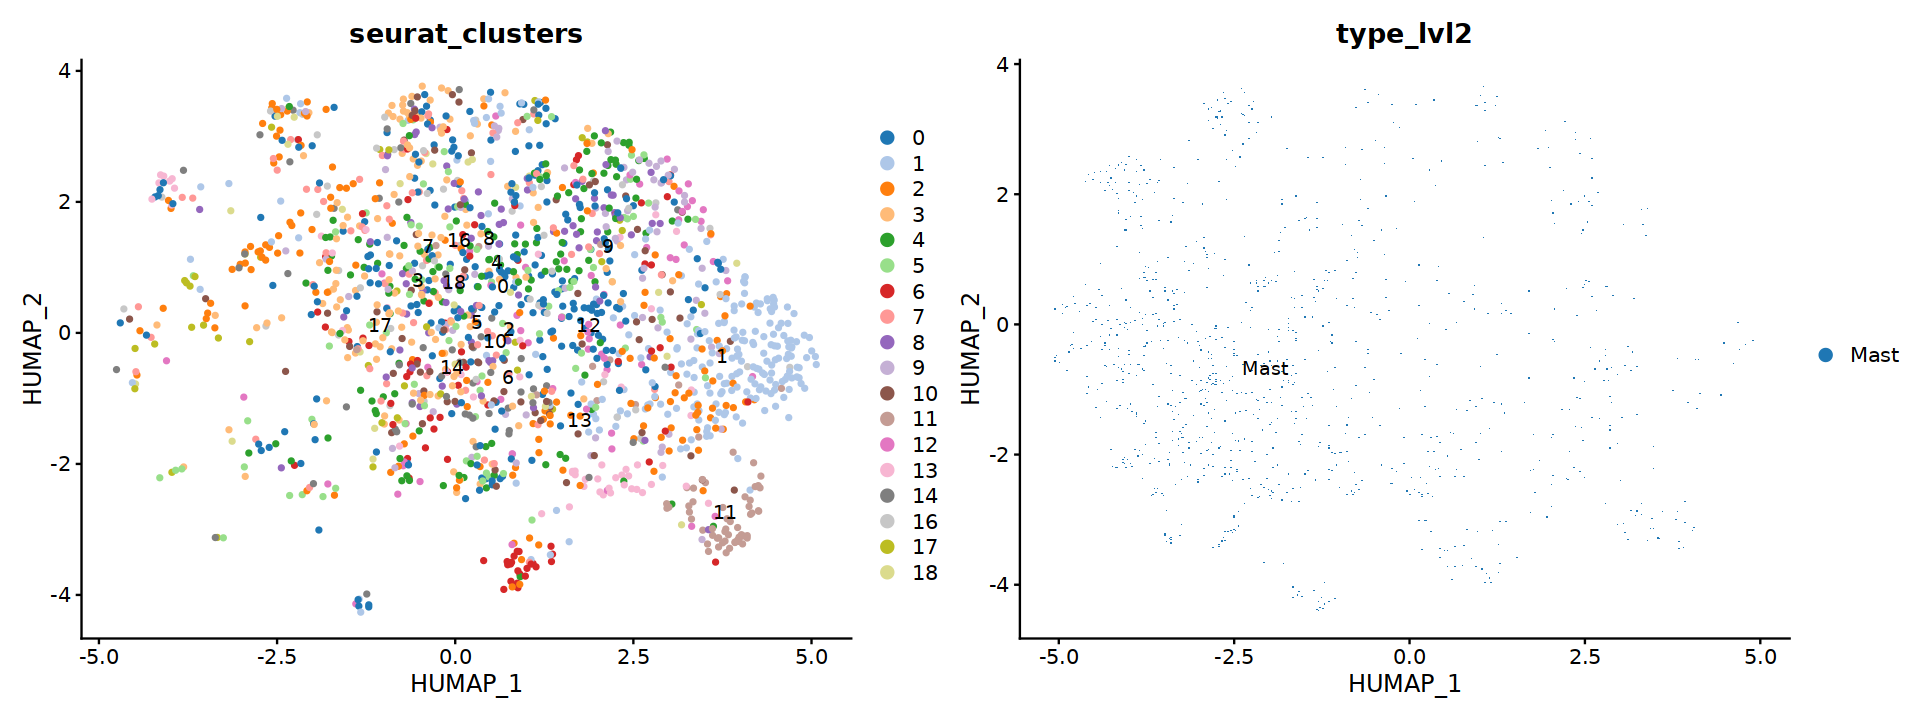

In [108]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'type_lvl2', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 10') 


### Infer counts

In [109]:
system.time({
    counts_imputed = impute_counts_knn(obj, k=5)    
})


   user  system elapsed 
  0.143   0.003   0.146 

In [110]:
counts_imputed[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
      2913 2955 3111 3210 3215
TGFB1    .    .    2    1    1
TGFB2    .    .    .    .    .
TGFB3    .    .    .    .    .
BMP2     .    .    .    .    .
BMP4     .    .    .    .    .

### Cache

In [111]:
spatula::writeMM(counts_imputed, '../data/counts_inferred_mast.mtx')
writeLines(colnames(counts_imputed), '../data/counts_inferred_mast_colnames.txt')
writeLines(rownames(counts_imputed), '../data/counts_inferred_mast_rownames.txt')


## B/Plasma

### data

In [112]:
table(meta_data$type_lvl1)


           Epithelial Fibroblast Lymphocyte       Mast    Myeloid     Plasma 
     15013      14420      13306      44414       1010      31999      11499 
  Vascular 
      8418 

In [113]:
cells = meta_data %>% 
    filter(type_lvl1 == 'Plasma' | type_lvl2 == 'B') %>% 
    with(cell)


In [114]:
table(meta_data[cell %in% cells, type_lvl1])
table(meta_data[cell %in% cells, type_lvl2])



Lymphocyte     Plasma 
      4661      11499 


     B Plasma 
  4661  11499 

In [115]:
# ref = readRDS('../data/tnk_ref_lee_lung.rds')
ref_meta = fread('../data/bplasma_ref_lee_lung_meta.csv')
ref_markers = fread('../data/bplasma_ref_lee_lung_markers.csv')
genes_ref = ref_markers[pvalue < .05 & logFC > 0][, unique(feature)]  
nrow(ref_meta)
length(genes_ref)


[1] 5377

[1] 202

### harmonize

In [116]:
obj <- Seurat::CreateSeuratObject(
    counts = Matrix::cbind2(
        counts[genes_ref, cells],
        counts_sc[genes_ref, ref_meta$cellid]
    ),
    meta.data = bind_rows(
        spatial = meta_data[match(cells, meta_data$cell), ] %>% 
            data.frame() %>% 
            tibble::column_to_rownames('cell') %>% 
            dplyr::select(batch=library, type_lvl2),
        sc = dplyr::select(tibble::column_to_rownames(data.frame(ref_meta), 'cellid'), batch=Sample, seurat_clusters, Cell_subtype), 
        .id = 'type'
    ) %>% 
        dplyr::select(type, batch, everything()) %>% 
        data.frame()
)


In [117]:
dim(obj)

[1]   202 21537

In [118]:
table(obj@meta.data$type)
table(is.na(obj@meta.data$type))



     sc spatial 
   5377   16160 


FALSE 
21537 

In [119]:
norm_factor = data.table(obj@meta.data)[, median(nCount_RNA), by = type][, median(V1)]
norm_factor

[1] 68

Warning message:
“The following arguments are not used: nselect”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



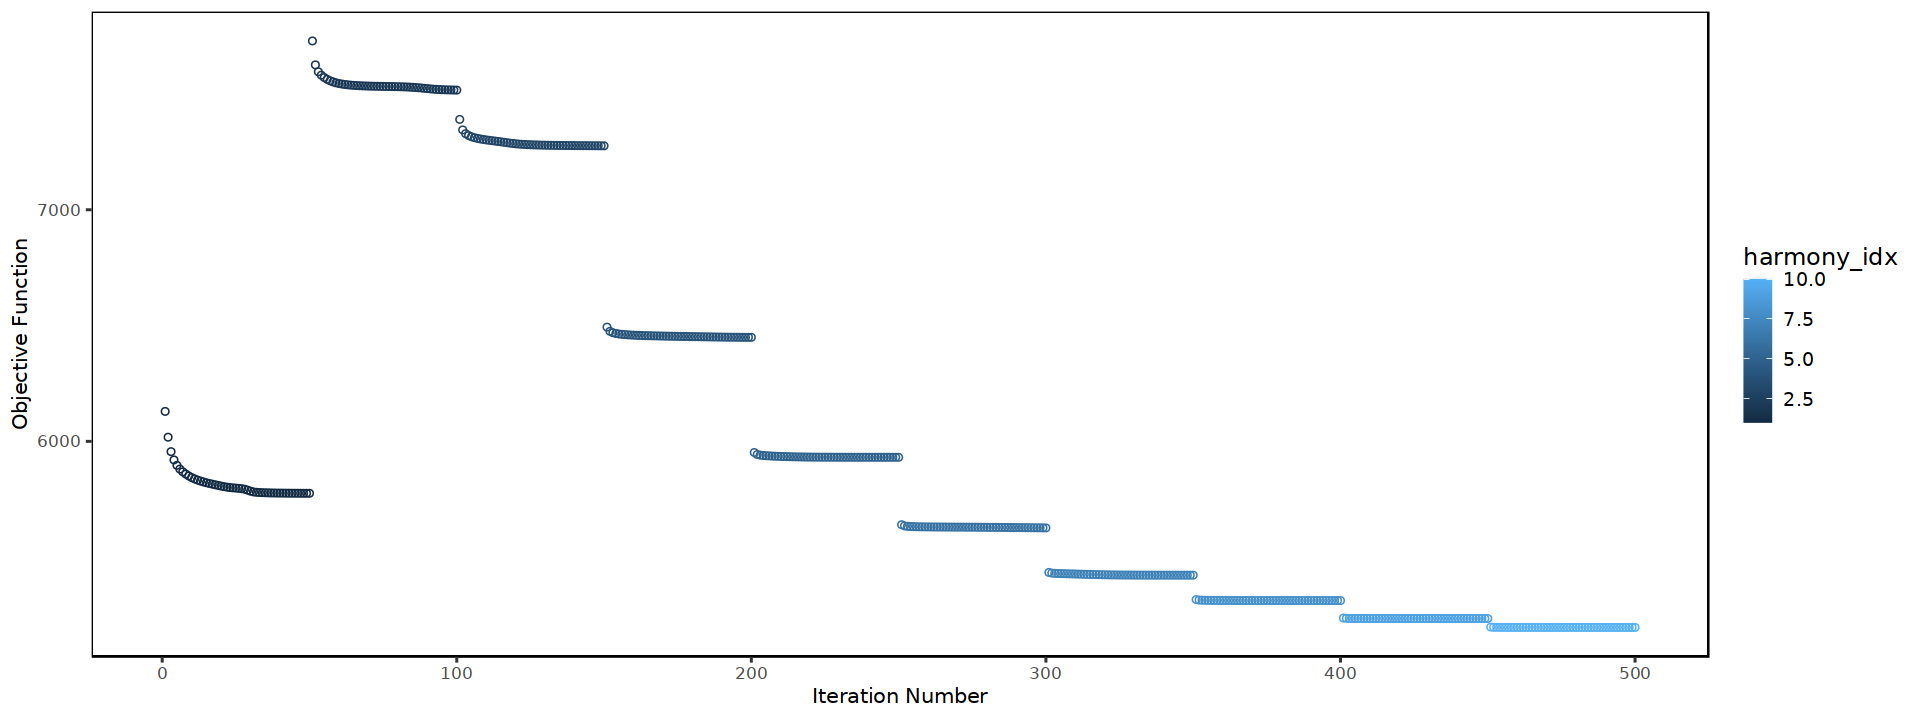

In [120]:
obj <- obj %>% 
    Seurat::NormalizeData(scale.factor = norm_factor) %>% 
    Seurat::FindVariableFeatures() %>% 
    RunBalancedPCA(weight.by = 'type') %>% 
    RunHarmony(
        c('type', 'batch'), 
        plot_convergence = TRUE,
        max.iter.harmony = 10, max.iter.cluster = 50,
        sigma = .15, 
        ## Try running harmony with low thetas first 
        theta = c(1, 0),
        
        ## For safety, avoid harmony stopping early 
        epsilon.cluster = -Inf, epsilon.harmony = -Inf,
        
        ## Protect against overintegrating small batches
        # tau = 5,
        
        ## This fails for some reason on the Seurat side 
        project.dim = FALSE
    ) %>% 
    identity()


In [121]:
library(Seurat)

In [122]:
system.time({
    U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.3, spread = 1.0, ret_extra = 'fgraph', fast_sgd = TRUE, n_sgd_threads = 60)     
    # U <- uwot::umap(obj@reductions$harmony@cell.embeddings, min_dist = 0.05, spread = 0.30, ret_extra = 'fgraph', approx_pow = TRUE, pcg_rand = FALSE, n_sgd_threads = 60)     
})

colnames(U$embedding) <- c('HUMAP1', 'HUMAP2')


Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’



   user  system elapsed 
 24.285   0.473   6.616 

In [123]:
rownames(U$fgraph) <- colnames(U$fgraph) <- Cells(obj)

obj[['humap']] <- Seurat::CreateDimReducObject(
    embeddings = U$embedding,
    assay = 'RNA', 
    key = 'HUMAP_', 
    global = TRUE
)
new_graph <- Seurat::as.Graph(U$fgraph)
DefaultAssay(new_graph) <- DefaultAssay(obj)
obj[['humap_fgraph']] <- new_graph

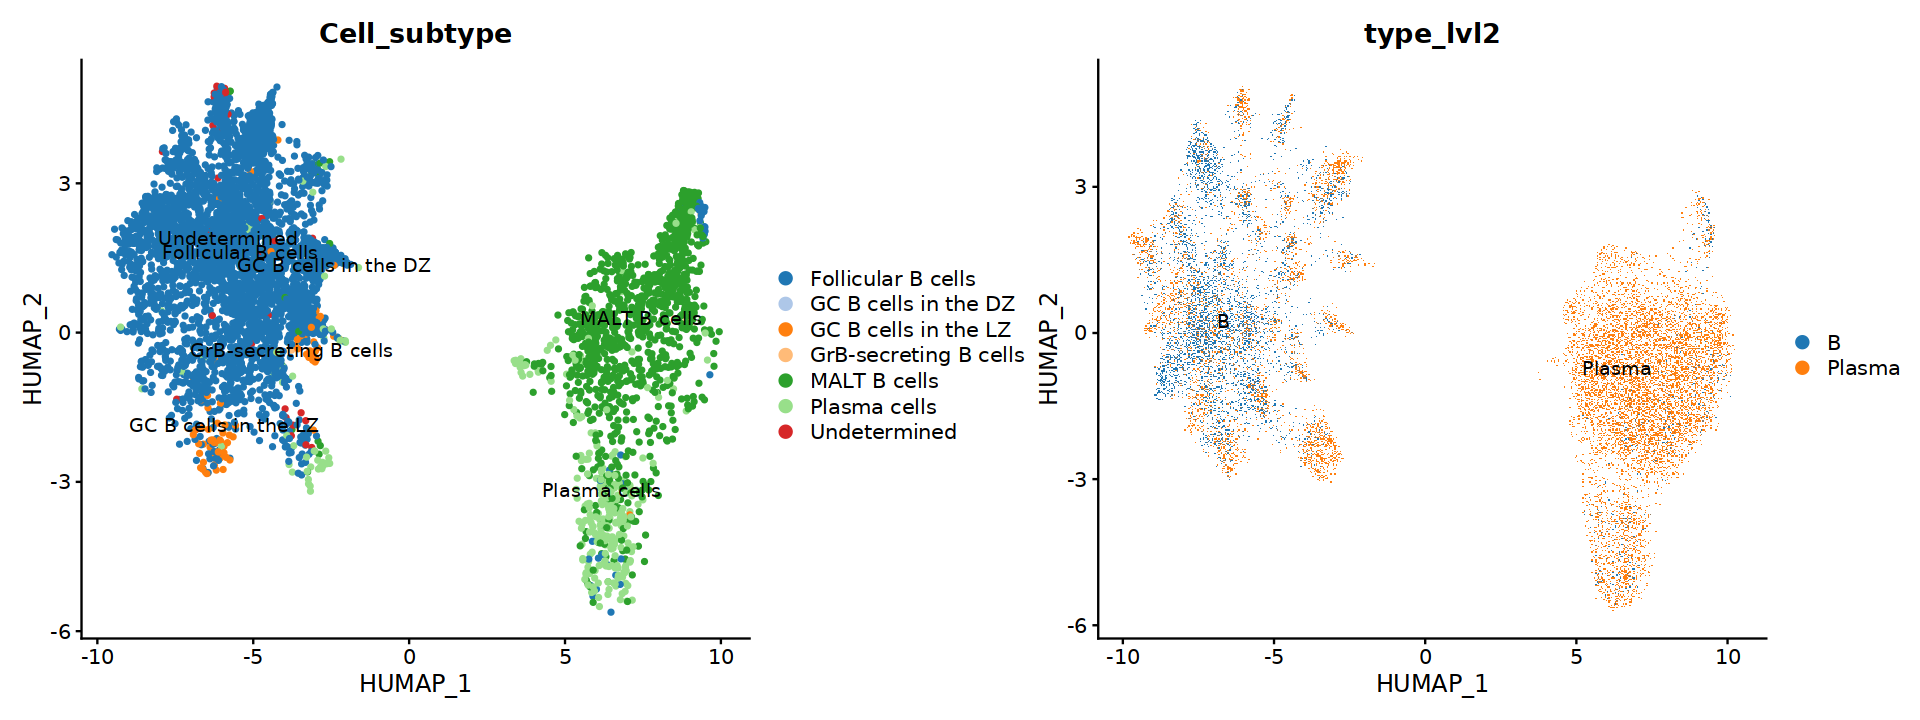

In [124]:
fig.size(6, 16)
DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'Cell_subtype', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
# DimPlot(subset(obj, type == 'sc'), reduction = 'humap', group.by = 'seurat_clusters', shuffle = TRUE, label = TRUE, pt.size = 1, raster = FALSE) + 
    scale_color_tableau('Classic 20') | 
DimPlot(subset(obj, type == 'spatial'), reduction = 'humap', group.by = 'type_lvl2', shuffle = TRUE, pt.size = 1, raster = TRUE, label = TRUE) + 
    scale_color_tableau('Classic 10') 


### Infer counts

In [125]:
system.time({
    counts_imputed = impute_counts_knn(obj, k=5)    
})


   user  system elapsed 
  5.066   0.112   5.177 

In [126]:
counts_imputed[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
      2660 2769 2865 2872 2881
TGFB1    .    1    2    1    2
TGFB2    .    .    .    .    .
TGFB3    .    .    .    .    .
BMP2     .    .    .    .    .
BMP4     .    .    .    .    .

### Cache

In [127]:
spatula::writeMM(counts_imputed, '../data/counts_inferred_bplasma.mtx')
writeLines(colnames(counts_imputed), '../data/counts_inferred_bplasma_colnames.txt')
writeLines(rownames(counts_imputed), '../data/counts_inferred_bplasma_rownames.txt')


## Combine results 

In [134]:
fnames = list.files('../data', pattern = 'counts_inferred_.*mtx')
types = gsub('counts_inferred_(.*).mtx', '\\1', fnames)
types = setdiff(types, 'all')
types


[1] "bplasma" "mast"    "myeloid" "stromal" "tnk"

In [135]:
plan(multicore)
system.time({
    mlist = glue('../data/counts_inferred_{types}.mtx') %>% future_map(spatula::readMM)    
})


   user  system elapsed 
  1.265   3.413   3.177 

In [137]:
mlist = map2(mlist, types, function(X, name) {
    colnames(X) = readLines(glue('../data/counts_inferred_{name}_colnames.txt'))
    rownames(X) = readLines(glue('../data/counts_inferred_{name}_rownames.txt'))
    X
}) 


In [138]:
length(readLines('../data/counts_inferred_stromal_colnames.txt'))


[1] 19149

In [139]:
counts_inferred = Reduce(Matrix::cbind2, mlist)


In [140]:
spatula::writeMM(counts_inferred, '../data/counts_inferred_all.mtx')
writeLines(colnames(counts_inferred), '../data/counts_inferred_all_colnames.txt')
writeLines(rownames(counts_inferred), '../data/counts_inferred_all_rownames.txt')


## Sanity check: predicted vs measured

# COMMOT 

## libraries

In [12]:
library(reticulate)
use_python('/home/ik97/anaconda3/envs/commot/bin/python')
scanpy = import('scanpy')
commot = import('commot')


## 0. data (meta_data; logcpx)

### Load

In [18]:
counts_inferred = spatula::readMM('../data/counts_inferred_all.mtx')
colnames(counts_inferred) = readLines('../data/counts_inferred_all_colnames.txt')
rownames(counts_inferred) = readLines('../data/counts_inferred_all_rownames.txt')


In [19]:
meta_data = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/lung_n4/cells/meta_data.csv')
meta_data$cell = as.character(meta_data$cell)
meta_data = meta_data[match(colnames(counts_inferred), meta_data$cell), ]


meta_data = meta_data %>% 
    left_join(fread('../data/stromal_fine_types.csv')[, .(cell, type_lvl1, type_lvl2)], by = 'cell') %>% 
    dplyr::mutate(
        type_lvl1 = case_when(
            type_lvl1.x %in% c('Fibroblast', 'Vascular') ~ type_lvl1.y, 
            TRUE ~ type_lvl1.x
        ),
        type_lvl2 = case_when(
            type_lvl1.x %in% c('Fibroblast', 'Vascular') ~ type_lvl2.y, 
            TRUE ~ type_lvl2.x
        )
    ) %>% 
    dplyr::select(-matches('\\.x$|\\.y$')) 

## Add new fine types, after stromal analysis 
## Make nice names for fibroblast subtypes
meta_data$fine_type = meta_data$type_lvl2#[match(rownames(adata$obs), meta_data$cell)] ## Attach new type_lvl2 names 
x = setNames(c('RSPO3+ Fibroblast', 'CCL19+ Fibroblast', 'FN1+ Fibroblast', 'IL6+ Fibroblast'), c('RSPO3+', 'CCL19+', 'FN+', 'IL6+'))
meta_data = meta_data %>% 
    dplyr::mutate(fine_type = case_when(
        fine_type %in% c('RSPO3+', 'CCL19+', 'FN+', 'IL6+') ~ x[fine_type], 
        TRUE ~ fine_type
    ))

In [26]:
logcpx = normalizeData(counts_inferred, median(colSums(counts_inferred)), 'log')

### subdivide huge hubs

In [27]:
nmax = 500
foo = function(.SD) {
    if (nrow(.SD) <= nmax) {
        return(rep('0', nrow(.SD)))
    } else {
        k = 2
        suppressWarnings({
            res = kmeans(.SD[, .(X, Y)], centers = k)$cluster
            while (mean(table(res)) > nmax) {
                k = k+1
                res = kmeans(.SD[, .(X, Y)], centers = k)$cluster
            }            
        })
        return(as.character(res))
    }
}

# m = meta_data[, .(hubID_sub = 6), by = hubID]
meta_data[, hubID_sub := foo(.SD), by = hubID]
meta_data$hubID = paste0(meta_data$hubID, '_', meta_data$hubID_sub)
hubs_keep = names(which(table(meta_data$hubID) >= 100))
meta_data = meta_data[hubID %in% hubs_keep]
logcpx = logcpx[, meta_data$cell]
counts = counts[, meta_data$cell]

Warning message in `[.data.table`(meta_data, , `:=`(hubID_sub, foo(.SD)), by = hubID):
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


ERROR: Error in eval(expr, envir, enclos): object 'counts' not found


In [44]:
saveRDS(logcpx, 'commot_cache/logcpx.rds')
saveRDS(meta_data, 'commot_cache/meta_data.rds')

## 1. Filter genes (df_cellchat)

In [15]:
logcpx = readRDS('commot_cache/logcpx.rds')
meta_data = readRDS('commot_cache/meta_data.rds')


In [16]:
obs = tibble::column_to_rownames(data.frame(meta_data), 'cell')


In [17]:
adata = scanpy$AnnData(
    X = Matrix::t(logcpx),
    obs = obs, 
    obsm = list(spatial = dplyr::select(obs, x=X, y=Y)),
    var = data.frame(row.names = rownames(logcpx), gene_ids = rownames(logcpx))
)


In [19]:
## Step 2: Choose LR database 
df_cellchat = commot$pp$ligand_receptor_database('CellChat', species = 'human', signaling_type = NULL)

colnames(df_cellchat) = c('ligand', 'receptors', 'pathway', 'type')
df_cellchat = df_cellchat %>% 
    dplyr::mutate(ligand = str_split(ligand, '_')) %>% 
    tidyr::unnest(ligand) %>% 
    dplyr::mutate(receptors = str_split(receptors, '_')) %>% 
    tidyr::unnest(receptors) %>% 
    filter(ligand %in% rownames(logcpx) & receptors %in% rownames(logcpx)) %>% 
    unique()
head(df_cellchat)
nrow(df_cellchat)

ligand,receptors,pathway,type
<chr>,<chr>,<chr>,<chr>
TGFB1,TGFBR1,TGFb,Secreted Signaling
TGFB1,TGFBR2,TGFb,Secreted Signaling
TGFB2,TGFBR1,TGFb,Secreted Signaling
TGFB2,TGFBR2,TGFb,Secreted Signaling
TGFB3,TGFBR1,TGFb,Secreted Signaling
TGFB3,TGFBR2,TGFb,Secreted Signaling


[1] 1657

In [20]:
df_cellchat_filtered = commot$pp$filter_lr_database(df_cellchat, adata, min_cell_pct=0.01)
colnames(df_cellchat_filtered) = colnames(df_cellchat)
nrow(df_cellchat_filtered)
nrow(df_cellchat)


[1] 1134

[1] 1657

In [283]:
# length(unique(df_cellchat_filtered$pathway))
# sort(table(df_cellchat_filtered$pathway), TRUE)

In [22]:
saveRDS(df_cellchat_filtered, 'commot_cache/df_cellchat.rds')

## 2. Infer cell-cell LR scores

~7 hours on 20 cores? 


In [5]:
df_cellchat_filtered = readRDS('commot_cache/df_cellchat.rds')
logcpx = readRDS('commot_cache/logcpx.rds')
meta_data = readRDS('commot_cache/meta_data.rds')
df_cellchat_split = df_cellchat_filtered %>% split(.$pathway) 


In [10]:
npathways = length(df_cellchat_split) 
nhubs = length(unique(meta_data$hubID))
npathways * nhubs

[1] 40248

In [11]:
fnames_done = list.files('commot', pattern = 'cache.*h5ad')
length(fnames_done)

[1] 40248

In [ ]:
plan(multicore, workers = 20)
for (hub in unique(meta_data$hubID)) {
# for (hub in hubs_next) {
    message(hub)
    i = which(meta_data$hubID == hub)
    logcpx_split = imap(df_cellchat_split, function(df_pathway, name) {
        g = unique(unlist(df_pathway[, 1:2]))    
        logcpx[g, i, drop = FALSE]
    })
    
    tryCatch({ 
        future_map2(df_cellchat_split, logcpx_split, function(df_pathway, logcpx_pathway) {
            pathway = unique(df_pathway$pathway)
            g = rownames(logcpx_pathway)
            fname_out = glue('commot/cache_{pathway}_{hub}_lr.h5ad')
            if (!file.exists(fname_out)) {
                message(glue('START RUNNING: commot/cache_{pathway}_{hub}_lr.h5ad'))
                tryCatch({
                    adata = scanpy$AnnData(
                        X = Matrix::t(logcpx_pathway),
                        obs = obs[i, ], 
                        obsm = list(spatial = dplyr::select(obs[i, ], x=X, y=Y)),
                        var = data.frame(row.names = g, gene_ids = g)
                    )
                    commot$tl$spatial_communication(
                        adata, 
                        database_name='cellchat', 
                        df_ligrec=df_pathway, 
                        dis_thr=100, 
                        # cot_nitermax=40, ## ONLY FOR TESTING
                        heteromeric=FALSE, 
                        pathway_sum=TRUE
                    )
                    adata$write_h5ad(fname_out)
                    return(0)
                }, error = function(e) {
                    message(e)
                    return(1)
                })
            } else {
                message(glue('***FILE ALREADY EXISTS: commot/cache_{pathway}_{hub}_lr.h5ad'))
                return(0)
            }
        })
    }, error = function(e) {
        message(glue('ERROR ON {hub}'))
        print(e)
    })
}


R1236_0

START RUNNING: commot/cache_ACTIVIN_R1236_0_lr.h5ad

START RUNNING: commot/cache_ADGRE5_R1236_0_lr.h5ad

START RUNNING: commot/cache_AGRN_R1236_0_lr.h5ad

START RUNNING: commot/cache_AGT_R1236_0_lr.h5ad

START RUNNING: commot/cache_ALCAM_R1236_0_lr.h5ad

START RUNNING: commot/cache_ANGPT_R1236_0_lr.h5ad

START RUNNING: commot/cache_ANGPTL_R1236_0_lr.h5ad

START RUNNING: commot/cache_ANNEXIN_R1236_0_lr.h5ad

Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
START RUNNING: commot/cache_ANXA1_R1236_0_lr.h5ad

START RUNNING: commot/cache_APELIN_R1236_0_lr.h5ad

START RUNNING: 

Runs on: 
- map, 1000 cells, 10 iterations 
- future_map sequential, 1000 cells, 10 iterations 
- future_map multisession, 1000 cells, 10 iterations 
- map, 10000 cells, 20 iterations: 7.7sec

- map, 10000 cells, 40 iterations: 9sec
- map, 20000 cells, 40 iterations: 35sec
- map, 5000 cells, 40 iterations: 2sec

- map, all cells, 10 iterations (yes, 3min)


40K cells might just be too much. If we split by hub instead of library, then we can avoid running COMMOT on >15K cells at once. 




## 3. Infer celltype-celltype scores

In [7]:
fnames = list.files('commot', pattern = 'cache.*h5ad', full.names = TRUE)
length(fnames)
head(fnames)

## Only run these
# fnames_done = list.files('commot', pattern = 'perm.*h5ad', full.names = TRUE)
# fnames = setdiff(fnames, gsub('perm', 'cache', fnames_done))

## Only run these 
## Revision
fnames_done = list.files('commot', pattern = 'permrev.*h5ad', full.names = TRUE)
fnames = setdiff(fnames, gsub('permrev', 'cache', fnames_done))

length(fnames)

[1] 40248

[1] "commot/cache_ACTIVIN_R1194_1_lr.h5ad" 
[2] "commot/cache_ACTIVIN_R1194_10_lr.h5ad"
[3] "commot/cache_ACTIVIN_R1194_11_lr.h5ad"
[4] "commot/cache_ACTIVIN_R1194_2_lr.h5ad" 
[5] "commot/cache_ACTIVIN_R1194_3_lr.h5ad" 
[6] "commot/cache_ACTIVIN_R1194_4_lr.h5ad"

[1] 0

### interactive

In [4]:
# ## update TCF7+ CD8 and CD4 names
# ## without touching the stromal names
# meta_data = fread('/n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/share/cells/meta_data.csv')[, .(cell, type_lvl2)][grepl('TCF7', type_lvl2)]
# meta_data$cell = as.character(meta_data$cell)


In [5]:
# fname = fnames[1]

In [85]:
# adata = scanpy$read_h5ad(fname)        

# ## REVISIONS: update CD8 and CD4 names 
# adata$obs$fine_type = as.character(adata$obs$fine_type)
# .m = meta_data[cell %in% rownames(adata$obs)]
# i = match(.m$cell, rownames(adata$obs))
# adata$obs$fine_type[i]= .m$type_lvl2
# adata$obs$fine_type = factor(adata$obs$fine_type)
# ## REVISIONS: update CD8 and CD4 names         

# pathway = gsub('.*cache_(.*?)_(.*)_lr.h5ad.*', '\\1', fname)
# fname_out = gsub('cache', 'permrev', fname)
# # lib = gsub('.*cache_(.*?)_(.*)_lr.h5ad.*', '\\2', fname)
# # fname_out = glue('commot/perm_{pathway}_{lib}_lr.h5ad')

#     commot$tl$cluster_communication(adata, database_name='cellchat', pathway_name=pathway, clustering='fine_type', n_permutations=100L)
#     lr_pairs = adata$uns$get('commot-cellchat-info')$df_ligrec[, 1:2]    
#     for (i in 1:nrow(lr_pairs)) {
#         lr_pair = as.character(unlist(lr_pairs[i, ]))
#         commot$tl$cluster_communication(adata, database_name='cellchat', lr_pair = lr_pair, clustering='fine_type', n_permutations=100L)    
#     }


In [ ]:
# plan(multicore)
plan(sequential)
res = future_map(fnames, function(fname) {
    tryCatch({
        adata = scanpy$read_h5ad(fname)        
        
        ## REVISIONS: update CD8 and CD4 names 
        adata$obs$fine_type = as.character(adata$obs$fine_type)
        .m = meta_data[cell %in% rownames(adata$obs)]
        i = match(.m$cell, rownames(adata$obs))
        adata$obs$fine_type[i]= .m$type_lvl2
        adata$obs$fine_type = factor(adata$obs$fine_type)
        ## REVISIONS: update CD8 and CD4 names         
        
        pathway = gsub('.*cache_(.*?)_(.*)_lr.h5ad.*', '\\1', fname)
        fname_out = gsub('cache', 'permrev', fname)
        # lib = gsub('.*cache_(.*?)_(.*)_lr.h5ad.*', '\\2', fname)
        # fname_out = glue('commot/perm_{pathway}_{lib}_lr.h5ad')
        
        if (!file.exists(fname_out)) {
            commot$tl$cluster_communication(adata, database_name='cellchat', pathway_name=pathway, clustering='fine_type', n_permutations=100L)
            lr_pairs = adata$uns$get('commot-cellchat-info')$df_ligrec[, 1:2]    
            for (i in 1:nrow(lr_pairs)) {
                lr_pair = as.character(unlist(lr_pairs[i, ]))
                commot$tl$cluster_communication(adata, database_name='cellchat', lr_pair = lr_pair, clustering='fine_type', n_permutations=100L)    
            }
            adata$write_h5ad(fname_out)    
        } else {
            message(glue('ALREADY PROCESSED FILE {fname_out}'))
            # message(glue('ALREADY PROCESSED FILE commot/perm_{pathway}_{lib}_lr.h5ad'))
        }
    }, error = function(e) {
        message(glue('FAILED ON {fname}'))
        print(e)
    })
})
# names(res) = hubs

### slurm batch (R)

Above, we have over 42,000 results. It will take too long to run them all on an interactive job. 

Below, I split them into 100 batches, 1 core each, ~380 jobs per core. Will this finish in 12 hours? 


`ISSUE` I seem to max out at 37 jobs. Is that right? If so, we should request for cores and parallelize that shit. 


In [14]:
njobs = 28
length(fnames) / njobs

[1] 1

In [15]:
cmds = split(fnames, sample(1:njobs, length(fnames), TRUE)) %>% 
    map_chr(function(.f) {
        str = paste(normalizePath(.f), collapse = ' ')
        cmd = glue('sbatch /n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/Revisions/commot.sh {str}') 
        cmd
    })


In [16]:
# cmd = glue('sbatch /n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/Revisions/commot.sh {normalizePath(fnames[[1]])}')
# writeLines(cmd)


In [17]:
# system(cmd, intern = TRUE)

In [18]:
.x = map(cmds, system, wait = FALSE)

In [ ]:
.x

### slurm batch (py)

Above, we have over 42,000 results. It will take too long to run them all on an interactive job. 

Below, I split them into 100 batches, 1 core each, ~380 jobs per core. Will this finish in 12 hours? 


`ISSUE` I seem to max out at 37 jobs. Is that right? If so, we should request for cores and parallelize that shit. 


In [32]:
length(fnames) / 100

[1] 380.16

In [30]:
cmds = split(fnames, sample(1:100, length(fnames), TRUE)) %>% 
    map_chr(function(.f) {
        str = paste(normalizePath(.f), collapse = ' ')
        cmd = glue('sbatch /n/data1/bwh/medicine/korsunsky/lab/ik97/NirMerfish/Revisions/commot.sh {str}') 
        cmd
    })


In [31]:
.x = map(cmds, system, wait = FALSE)

## 4. collect final results (per hub)

~XXmin on 20 cores


In [58]:
all_types = union(
    unique(fread('../share/cells/markers_lvl2.csv')$cluster),
    unique(fread('../data/stromal_fine_types.csv')$type_lvl2)
)
all_types = all_types[all_types != '']
all_types[all_types == 'FN+'] = 'FN1+'
all_types[which(all_types %in% c('CCL19+', 'FN1+', 'IL6+', 'RSPO3+'))] = paste(all_types[which(all_types %in% c('CCL19+', 'FN1+', 'IL6+', 'RSPO3+'))], 'Fibroblast')


In [59]:
plan(multicore)
res = future_map(hubs, function(hub) {
# res = map(hubs, function(hub) {
    # message(hub)
    fnames_hub = grep(glue('commot/permrev_.*_{hub}_lr.h5ad'), fnames, value = TRUE)    
    # fnames_hub = grep(glue('commot/perm_.*_{hub}_lr.h5ad'), fnames, value = TRUE)    
    # map(fnames_hub, function(fname) {
    future_map(fnames_hub, function(fname) {
        adata = scanpy$read_h5ad(fname)
        pathway = gsub('.*permrev_(.*)_(R\\d+_\\d+)_lr.*', '\\1', fname) ## hubID: R\\d+_\\d+
        # pathway = gsub('.*perm_(.*)_(R\\d+)_lr.*', '\\1', fname)
        str = as.character(adata$uns$keys())
        lr_keys = grep('commot_cluster.*cellchat-.+', str_split(str, "'")[[1]], value = TRUE)
        res_pval = lr_keys %>% 
            map(function(key) adata$uns$get(key)$communication_pvalue) %>% 
            setNames(nm = lr_keys) %>% 
            map(as.matrix) %>% 
            abind(along = 3)
        res_score = lr_keys %>% 
            map(function(key) adata$uns$get(key)$communication_matrix) %>% 
            setNames(nm = lr_keys) %>% 
            map(as.matrix) %>% 
            abind(along = 3)

        dimnames(res_pval)[[3]] = gsub('commot_cluster-fine_type-cellchat-', '', dimnames(res_pval)[[3]])
        i = which(dimnames(res_pval)[[3]] == pathway)
        dimnames(res_pval)[[3]][i] = paste0('pathway_', dimnames(res_pval)[[3]][i])
        dimnames(res_pval)[[3]] = paste0(dimnames(res_pval)[[3]], ':', pathway)

        dimnames(res_score)[[3]] = gsub('commot_cluster-fine_type-cellchat-', '', dimnames(res_score)[[3]])
        i = which(dimnames(res_score)[[3]] == pathway)
        dimnames(res_score)[[3]][i] = paste0('pathway_', dimnames(res_score)[[3]][i])
        dimnames(res_score)[[3]] = paste0(dimnames(res_score)[[3]], ':', pathway)
        res = abind(res_pval, res_score, along = 4)
        dimnames(res)[[4]] = c('pval', 'score')

        ## Account for missing types: fill with NA 
        res_fill = array(
            NA, 
            dim = c(length(all_types), length(all_types), dim(res)[3], 2),
            dimnames = list(all_types, all_types, dimnames(res)[[3]], dimnames(res)[[4]])
        )
        res_fill[rownames(res), colnames(res), , ] = res            
        return(res_fill)
    }) %>% 
    # }, .options = furrr_options(seed = TRUE)) %>% 
        abind(along = 3)
}, .options = furrr_options(seed = TRUE))
# })
names(res) = hubs


In [60]:
length(res)

[1] 258

In [62]:
pryr::object_size(res)

7.69 GB

### Cache

In [63]:
saveRDS(res, 'commot/summary_final_results_by_hubs_revision.rds')
# saveRDS(res, 'commot/summary_final_results_by_hubs.rds')


## 5. Summarize over hubs

In [2]:
res = readRDS('commot/summary_final_results_by_hubs_revision.rds')
# res = readRDS('commot/summary_final_results_by_hubs.rds')


In [66]:
pryr::object_size(res)

7.69 GB

In [67]:
grep('HLA', dimnames(res[[1]])[[3]], value = TRUE)

[1] "HLA-A-CD8A:MHC-I"    "HLA-A-CD8B:MHC-I"    "HLA-B-CD8A:MHC-I"   
 [4] "HLA-B-CD8B:MHC-I"    "HLA-B-KIR3DL2:MHC-I" "HLA-C-CD8A:MHC-I"   
 [7] "HLA-C-CD8B:MHC-I"    "HLA-C-KIR2DL3:MHC-I" "HLA-E-CD8A:MHC-I"   
[10] "HLA-E-CD8B:MHC-I"    "HLA-E-KLRC1:MHC-I"   "HLA-E-KLRC2:MHC-I"  
[13] "HLA-E-KLRD1:MHC-I"   "HLA-F-CD8A:MHC-I"    "HLA-F-CD8B:MHC-I"   
[16] "HLA-F-KIR3DL2:MHC-I" "HLA-F-LILRB1:MHC-I"  "HLA-G-CD8A:MHC-I"   
[19] "HLA-G-CD8B:MHC-I"    "HLA-G-LILRB1:MHC-I"  "HLA-G-LILRB2:MHC-I" 
[22] "HLA-DMA-CD4:MHC-II"  "HLA-DMB-CD4:MHC-II"  "HLA-DOA-CD4:MHC-II" 
[25] "HLA-DOB-CD4:MHC-II"  "HLA-DPA1-CD4:MHC-II" "HLA-DPB1-CD4:MHC-II"
[28] "HLA-DQA1-CD4:MHC-II" "HLA-DQA2-CD4:MHC-II" "HLA-DQB1-CD4:MHC-II"
[31] "HLA-DRA-CD4:MHC-II"  "HLA-DRB1-CD4:MHC-II" "HLA-DRB5-CD4:MHC-II"

### mean scores

In [82]:
## Not all results have all cell types or all pathways
types = res %>% map(dimnames) %>% map(1) %>% reduce(union)
ntypes = length(types)
pathways = res %>% map(dimnames) %>% map(3) %>% map(as.character) %>% reduce(union)
npathways = length(pathways)

## sum over all scores 
## keep track of num observations, for averaging 
res_summary = array(data = 0, dim = c(ntypes, ntypes, length(pathways), 2), dimnames = list(types, types, pathways, c('pval', 'score')))
# res_summary = array(data = 0, dim = c(ntypes, ntypes, length(pathways), 3), dimnames = list(types, types, pathways, dimnames(res[[1]])[[4]]))


res_summary_n = array(data = 0, dim = c(ntypes, ntypes), dimnames = list(types, types))
for (.res in res) {
    ## get non-missing types and pathways 
    types_na = names(which(apply(is.na(.res), 1, all)))
    .types = setdiff(rownames(.res), types_na)
    pathways_na = names(which(apply(is.na(.res), 3, all)))
    .pathways = setdiff(dimnames(.res)[[3]], pathways_na)
    
    ## add them to summary stats
    res_summary_n[.types, .types] = res_summary_n[.types, .types] + 1
    res_summary[.types, .types, .pathways, 'score'] = res_summary[.types, .types, .pathways, 'score'] + .res[.types, .types, .pathways, 'score']
    res_summary[.types, .types, .pathways, 'pval'] = res_summary[.types, .types, .pathways, 'pval'] + log(pmax(.res[.types, .types, .pathways, 'pval'], .01))  
    # res_summary[.types, .types, , 'score'] = res_summary[.types, .types, , 'score'] + .res[, , , 'score']
    # res_summary[.types, .types, , 'pval'] = res_summary[.types, .types, , 'pval'] + log(pmax(.res[, , , 'pval'], .01))    
}

## divide by number of observations to get mean scores
for (i in 1:length(pathways)) {
    res_summary[, , i, 'score'] = res_summary[, , i, 'score'] / res_summary_n
    res_summary[, , i, 'pval'] = res_summary[, , i, 'pval'] / res_summary_n
}    
res_summary[, , , 'pval'] = exp(res_summary[, , , 'pval'])


In [76]:
# res_summary[, , 'HLA-A-CD8B:MHC-I', 1]

In [85]:
res_summary['LAMP3+CCL19+ mreg DC', 'TCF7+ CD8 T', , ] %>% data.frame() %>% 
    tibble::rownames_to_column('pathway') %>% 
    dplyr::arrange(-score) %>% 
    # filter(grepl('.+-.+:.*', pathway)) %>% 
    filter(!grepl('pathway', pathway)) %>% 
    filter(pval < .05) %>% 
    # filter(grepl('CCL', pathway)) %>% 
    identity()

pathway,pval,score
<chr>,<dbl>,<dbl>
CD86-CD28:CD86,0.03459035,0.004779366
ALCAM-CD6:ALCAM,0.03568614,0.004139360
CD274-PDCD1:PD-L1,0.04082765,0.003659729
EBI3-IL27RA:IL12,0.03661430,0.002099469
CD80-CD28:CD80,0.03050783,0.001983139
ICOSLG-ICOS:ICOS,0.03875204,0.001750193
ICOSLG-CD28:ICOS,0.04486043,0.001721934
CD80-CTLA4:CD80,0.04622806,0.001447637


In [86]:
res_summary['LAMP3+CCL19+ mreg DC', 'Treg', , ] %>% data.frame() %>% 
# res_summary['LAMP3+CCL19+ mreg DC', 'TCF7+ CD8 T', , ] %>% data.frame() %>% 
    tibble::rownames_to_column('pathway') %>% 
    dplyr::arrange(-score) %>% 
    # filter(grepl('.+-.+:.*', pathway)) %>% 
    filter(!grepl('pathway', pathway)) %>% 
    filter(pval < .05) %>% 
    # filter(grepl('CCL', pathway)) %>% 
    identity()


pathway,pval,score
<chr>,<dbl>,<dbl>
CD86-CTLA4:CD86,0.01118408,0.0104604590
CD86-CD28:CD86,0.01197103,0.0073992249
CXCL16-CXCR6:CXCL,0.01519488,0.0072939644
SELPLG-SELL:SELPLG,0.02292264,0.0042837381
ALCAM-CD6:ALCAM,0.01758123,0.0042146703
CD80-CTLA4:CD80,0.01182990,0.0042090519
CD274-PDCD1:PD-L1,0.01669871,0.0038906244
LGALS9-PTPRC:GALECTIN,0.01845962,0.0038344326
EBI3-IL27RA:IL12,0.01592272,0.0035994227


### Cache

In [87]:
saveRDS(res_summary, 'commot/summary_final_results_full_revision.rds')
# saveRDS(res_summary, 'commot/summary_final_results_full.rds')


### Export to spreadsheet

In [88]:
grep('HLA', dimnames(res_summary)[[3]], value = TRUE)

[1] "HLA-A-CD8A:MHC-I"    "HLA-A-CD8B:MHC-I"    "HLA-B-CD8A:MHC-I"   
 [4] "HLA-B-CD8B:MHC-I"    "HLA-B-KIR3DL2:MHC-I" "HLA-C-CD8A:MHC-I"   
 [7] "HLA-C-CD8B:MHC-I"    "HLA-C-KIR2DL3:MHC-I" "HLA-E-CD8A:MHC-I"   
[10] "HLA-E-CD8B:MHC-I"    "HLA-E-KLRC1:MHC-I"   "HLA-E-KLRC2:MHC-I"  
[13] "HLA-E-KLRD1:MHC-I"   "HLA-F-CD8A:MHC-I"    "HLA-F-CD8B:MHC-I"   
[16] "HLA-F-KIR3DL2:MHC-I" "HLA-F-LILRB1:MHC-I"  "HLA-G-CD8A:MHC-I"   
[19] "HLA-G-CD8B:MHC-I"    "HLA-G-LILRB1:MHC-I"  "HLA-G-LILRB2:MHC-I" 
[22] "HLA-DMA-CD4:MHC-II"  "HLA-DMB-CD4:MHC-II"  "HLA-DOA-CD4:MHC-II" 
[25] "HLA-DOB-CD4:MHC-II"  "HLA-DPA1-CD4:MHC-II" "HLA-DPB1-CD4:MHC-II"
[28] "HLA-DQA1-CD4:MHC-II" "HLA-DQA2-CD4:MHC-II" "HLA-DQB1-CD4:MHC-II"
[31] "HLA-DRA-CD4:MHC-II"  "HLA-DRB1-CD4:MHC-II" "HLA-DRB5-CD4:MHC-II"

In [89]:
res_tidy = map(types, function(t1) {
    map(types, function(t2) {
        res_summary[t1,t2, , ] %>% 
            data.frame() %>% 
            dplyr::mutate(sender = t1, receiver = t2) %>% 
            tibble::rownames_to_column('pathway')
    }) %>%
        bind_rows() 
}) %>% 
    bind_rows() %>% 
    filter(!grepl('pathway', pathway)) %>% 
    tidyr::separate(pathway, c('pair', 'pathway'), ':') %>% 
    dplyr::select(sender, receiver, pathway, pair, score, pval) %>% 
    # tidyr::separate(pair, c('ligand', 'receptor'), '-') 
    dplyr::mutate(
        ligand = gsub('(.*)-(.*)', '\\1', pair),
        receptor = gsub('(.*)-(.*)', '\\2', pair)
    ) %>% 
    dplyr::select(-pair)


In [90]:
res_tidy %>% 
    fwrite('commot/commot_final_tidy.csv')

In [91]:
nrow(res_tidy)

[1] 1637496

In [92]:
res_tidy = res_tidy %>% 
    filter(pval < .05) %>% 
    filter(sender != receiver) %>% 
    arrange(-score) 

In [93]:
nrow(res_tidy)

[1] 17868

In [94]:
head(res_tidy)

,sender,receiver,pathway,score,pval,ligand,receptor
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Lymphatic,TCF7+ CD4 T,CCL,0.07581583,0.01418408,CCL21,CCR7
2,Venous,Mast,IL1,0.06183109,0.01088171,IL33,IL1RL1
3,Lymphatic,CD4 T,CCL,0.05767564,0.01285806,CCL21,CCR7
4,Arterial,Mast,IL1,0.05220236,0.01408811,IL33,IL1RL1
5,CCL19+ Fibroblast,TCF7+ CD4 T,CCL,0.05084509,0.01503095,CCL19,CCR7
6,Pericyte,Mast,KIT,0.04608369,0.01648709,KITLG,KIT


In [101]:
res_tidy = res_tidy %>% 
    dplyr::mutate(
        sender = case_when(
            sender == 'CD4 T' ~ 'TCF7- CD4 T', 
            sender == 'CD8 T' ~ 'TCF7- CD8 T', 
            sender == 'TCF7+ CD8 T' ~ 'TCF7+PD1- CD8 T', 
            TRUE ~ sender
        )
    ) %>% 
    dplyr::mutate(
        sender = case_when(
            sender == 'CD4 T' ~ 'TCF7- CD4 T', 
            sender == 'CD8 T' ~ 'TCF7- CD8 T', 
            sender == 'TCF7+ CD8 T' ~ 'TCF7+PD1- CD8 T', 
            TRUE ~ sender
        )
    )

In [103]:
writeLines(sort(unique(res_tidy$sender)))

Arterial
B
CCL19+ Fibroblast
CD1C+ITGAX+ DC
CXCL10+ Macrophage
CXCL13+ CD4 T
CXCL13+ CD8 T
FCN1+LYZ+ Macrophage
FLT3+ DC
FN1+ Fibroblast
FOLR2+CD14+ Macrophage
IL6+ Fibroblast
ILC
LAMP3+CCL19+ mreg DC
LAMP3+CD1C+ DC
Lymphatic
MARCO+ Macrophage
Mast
MERTK+ Macrophage
MMP1+SOX4+ Myeloid
NCAM1+ S100B+ SEPP1+ Myeloid
NK
Pericyte
PLA2G7+ CCL18+ Macrophage
Plasma
RSPO3+ Fibroblast
SmoothMuscle
SPP1+ Macrophage
TCF7- CD4 T
TCF7- CD8 T
TCF7+ CD4 T
TCF7+PD1- CD8 T
TCF7+PD1+ CD8 T
Treg
Venous


In [104]:
res_tidy %>% 
    fwrite('figures/commot_final_p05.csv')

### Intersect with coloc (TODO)

In [88]:
# res = fread('../tables/colocalization_stats.csv')[hubType == 'hybrid_hub']



In [105]:
res_meta = fread('../data/colocalization_stats_revision_meta.csv')

In [107]:
res_meta[grepl('mreg', index_type)][order(-zscore)][fdr < .01]
res_meta[grepl('cxcl10', index_type, ignore.case = TRUE)][order(-zscore)][fdr < .01]


index_type,type,hubType,freq,zscore,pval,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
LAMP3+CCL19+ mreg DC,Treg,stem_immunity,1.05019455,12.464139,5.856527e-36,5.256819e-32
LAMP3+CCL19+ mreg DC,CD4 T,stem_immunity,1.33096636,10.966364,2.772901e-28,2.488956e-24
LAMP3+CCL19+ mreg DC,Treg,activated_immunity,0.70606481,8.791262,7.394459e-19,6.637266e-15
LAMP3+CCL19+ mreg DC,FLT3+ DC,activated_immunity,0.13385115,7.475566,3.843619e-14,3.450033e-10
LAMP3+CCL19+ mreg DC,B,stem_immunity,0.47839196,6.825201,4.390126e-12,3.940577e-08
LAMP3+CCL19+ mreg DC,LAMP3+CD1C+ DC,stem_immunity,0.08153181,5.971416,1.176017e-09,1.055593e-05
LAMP3+CCL19+ mreg DC,LAMP3+CD1C+ DC,activated_immunity,0.13385115,5.790422,3.510496e-09,3.151021e-05
LAMP3+CCL19+ mreg DC,CD1C+ITGAX+ DC,activated_immunity,0.19073789,5.686902,6.468215e-09,5.805870e-05
LAMP3+CCL19+ mreg DC,FLT3+ DC,stem_immunity,0.11500845,5.339173,4.668576e-08,4.190513e-04


index_type,type,hubType,freq,zscore,pval,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CXCL10+ Macrophage,CD8 T,activated_immunity,0.5108228,18.036358,5.049146e-73,4.532113e-69
CXCL10+ Macrophage,Treg,activated_immunity,0.4676848,12.506623,3.434132e-36,3.082477e-32
CXCL10+ Macrophage,ILC,activated_immunity,0.3267387,11.101551,6.164305e-29,5.533080e-25
CXCL10+ Macrophage,CD8 T,stem_immunity,0.7614524,9.909208,1.898218e-23,1.703840e-19
CXCL10+ Macrophage,MARCO+ Macrophage,activated_immunity,0.9759450,9.404436,2.615490e-21,2.347664e-17
CXCL10+ Macrophage,ILC,stem_immunity,0.4514699,7.241572,2.217563e-13,1.990485e-09
CXCL10+ Macrophage,MERTK+ Macrophage,activated_immunity,0.5266259,6.867026,3.277716e-12,2.942078e-08
CXCL10+ Macrophage,CD1C+ITGAX+ DC,stem_immunity,0.1648671,6.176101,3.285190e-10,2.948787e-06
CXCL10+ Macrophage,MARCO+ Macrophage,stem_immunity,0.3470675,5.529277,1.607766e-08,1.443131e-04


## 6. Figure


In [92]:
# res_summary = readRDS('commot/summary_final_results_full.rds')

In [93]:
# writeLines(sort(unique(fread('commot/commot_final_tidy.csv')$pathway)))

In [94]:
fread('commot/commot_final_tidy.csv')[grepl('HLA', ligand)] %>% 
    head

sender,receiver,pathway,score,pval,ligand,receptor
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
B,B,MHC-I,2.074688e-03,0.7950514,HLA-A,CD8A
B,B,MHC-I,1.035303e-03,0.8899298,HLA-A,CD8B
B,B,MHC-I,2.233351e-03,0.7806244,HLA-B,CD8A
B,B,MHC-I,1.206480e-03,0.8701843,HLA-B,CD8B
B,B,MHC-I,6.727817e-05,0.9309836,HLA-B,KIR3DL2
B,B,MHC-I,2.041016e-03,0.7925077,HLA-C,CD8A


In [10]:
# fread('commot/commot_final_tidy.csv')[
#     sender %in% c('CXCL10+ Macrophage', 'LAMP3+CCL19+ mreg DC', 'CCL19+ Fibroblast') & 
#     receiver %in% c('Treg', 'CD4 T', 'CD8 T', 'B', 'Tgd')
# ][, sum(score), by = .(pathway, sender, receiver)][order(-V1)]


In [99]:
# writeLines(sort(unique(fread('commot/commot_final_tidy.csv')$pathway)))


In [142]:
# writeLines(sort(unique(fread('commot/commot_final_tidy.csv')$sender)))

In [207]:
fread('commot/commot_final_tidy.csv')

In [ ]:
fread('commot/commot_final_tidy.csv')[
    , zempirical := scale(score), by = .(sender, receiver)
    # , zempirical := scale(score), by = sender
][] %>% 
    ggplot(aes(zempirical, sender)) + 
        geom_den

sender,receiver,pathway,score,pval,ligand,receptor,zempirical
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
B,B,ACTIVIN,1.265031e-06,0.98881670,INHBA,ACVR1B,-0.2073846
B,B,ACTIVIN,2.269621e-05,0.86131176,INHBA,ACVR1C,-0.1991956
B,B,ACTIVIN,1.295397e-06,0.99391805,INHBA,ACVR2A,-0.2073730
B,B,ACTIVIN,3.359612e-05,0.91239445,INHBA,ACVR2B,-0.1950307
B,B,ACTIVIN,0.000000e+00,1.00000000,INHBB,ACVR1B,-0.2078680
B,B,ACTIVIN,0.000000e+00,1.00000000,INHBB,ACVR1C,-0.2078680
B,B,ACTIVIN,0.000000e+00,1.00000000,INHBB,ACVR2A,-0.2078680
B,B,ACTIVIN,0.000000e+00,1.00000000,INHBB,ACVR2B,-0.2078680
B,B,ADGRE5,3.121613e-02,0.03311957,ADGRE5,CD55,11.7200277


In [464]:
fread('commot/commot_final_tidy.csv')[
    , zempirical := scale(score), by = .(sender, receiver)
    # , zempirical := scale(score), by = sender
][] %>% 
    fwrite('commot/commot_final_tidy_zemp.csv')


In [454]:
df = fread('commot/commot_final_tidy.csv')[
    , zempirical := scale(score), by = .(sender, receiver)
    # , zempirical := scale(score), by = sender
][
    # sender %in% c('CXCL10+ Macrophage', 'LAMP3+CCL19+ mreg DC') & 
    sender %in% c('CXCL10+ Macrophage', 'LAMP3+CCL19+ mreg DC', 'CCL19+ Fibroblast') & 
    receiver %in% c('Treg', 'CD4 T', 'CD8 T', 'B', 'ILC') & 
    TRUE
][
    # pathway %in% c('CX3C', 'CXCL', 'CCL') | grepl('^IL\\d', pathway)
    pathway %in% c('CX3C', 'CXCL', 'CCL') | grepl('^IL\\d', pathway) | grepl('^CD\\d', pathway) 
][
    , `:=`(
        lr = paste(ligand, receptor, sep=':'),
        pair = paste(sender, receiver, sep=':')
    )
][]


df = df[lr %in% unique(df[pval < .05, lr])]

df = df %>% 
    left_join(
        res_meta[hubType == 'stem_immunity', .(index_type, type, zscore_coloc=zscore, pval_coloc=pval, fdr_coloc=fdr)], 
        by = c('sender' = 'index_type', 'receiver' = 'type')
        # by = c('sender' = 'index_type', 'receiver' = 'type')
    )

head(df)
nrow(df)

length(unique(df$lr))

df$score2 = df$zempirical
# df$score2 =  -log10(df$pval)
# df$score2 =  -log10(df$pval)
# df$score2 =  df$score
# df$score2 = (df$pval_coloc < .01) * df$score


df$score2 = (df$fdr_coloc < .01) * df$score2


sender,receiver,pathway,score,pval,ligand,receptor,zempirical,lr,pair,zscore_coloc,pval_coloc,fdr_coloc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
LAMP3+CCL19+ mreg DC,B,CCL,3.064339e-06,0.96182274,CCL17,CCR4,-0.1831118,CCL17:CCR4,LAMP3+CCL19+ mreg DC:B,6.825201,4.390126e-12,3.940577e-08
LAMP3+CCL19+ mreg DC,B,CCL,3.527678e-03,0.03197998,CCL19,CCR7,11.7721592,CCL19:CCR7,LAMP3+CCL19+ mreg DC:B,6.825201,4.390126e-12,3.940577e-08
LAMP3+CCL19+ mreg DC,B,CCL,4.460270e-04,0.37520643,CCL20,CCR6,1.3193900,CCL20:CCR6,LAMP3+CCL19+ mreg DC:B,6.825201,4.390126e-12,3.940577e-08
LAMP3+CCL19+ mreg DC,B,CCL,4.063521e-04,0.29046282,CCL21,CCR7,1.1848150,CCL21:CCR7,LAMP3+CCL19+ mreg DC:B,6.825201,4.390126e-12,3.940577e-08
LAMP3+CCL19+ mreg DC,B,CCL,1.745870e-06,0.97062675,CCL22,CCR4,-0.1875840,CCL22:CCR4,LAMP3+CCL19+ mreg DC:B,6.825201,4.390126e-12,3.940577e-08
LAMP3+CCL19+ mreg DC,B,CCL,9.135651e-05,0.50874115,CCL3,CCR5,0.1163697,CCL3:CCR5,LAMP3+CCL19+ mreg DC:B,6.825201,4.390126e-12,3.940577e-08


[1] 465

[1] 31

In [455]:
# df %>% 
#     ggplot(aes(score)) + 
#         geom_histogram() + 
#         facet_wrap(~sender, scales = 'free')


In [456]:
# fig.size(5, 8)
# df %>% 
#     # ggplot(aes(score, pval)) + 
#     ggplot(aes(zempirical, -log10(pval))) + 
#         # geom_point(aes(color = pathway)) + 
#         geom_point(aes(color = receiver)) + 
#         # scale_x_log10() + 
#         geom_hline(yintercept = -log10(.05), linetype = 2) + 
#         geom_vline(xintercept = 2) + 
#         scale_color_tableau() + 
#         facet_wrap(~sender, scales = 'free') 


In [457]:
X = df[, .(pair, lr, score2)] %>% 
    data.frame() %>% 
    tidyr::spread(pair, score2) %>% 
    tibble::column_to_rownames('lr') %>% 
    as.matrix() %>% 
    t() 

# X = df[, .(pair, lr, score2)] %>% 
#     data.frame() %>% 
#     tidyr::spread(pair, score2) %>% 
#     tibble::column_to_rownames('lr') %>% 
#     as.matrix() %>% 
#     t() 

In [459]:
# .X = X[which(rowSums(X == 0) < ncol(X)), ] %>% t %>% scale %>% t ## scale within cell type pair
.X = X[which(rowSums(X == 0) < ncol(X)), ] 
# .X = .X[, which(apply(.X, 2, max) >= 1)]


row_levels = c(
    'LAMP3+CCL19+ mreg DC:Treg',
    'LAMP3+CCL19+ mreg DC:CD4 T',
    'LAMP3+CCL19+ mreg DC:B',
    'CCL19+ Fibroblast:CD4 T',
    'CCL19+ Fibroblast:B',
    'CXCL10+ Macrophage:CD8 T',
    'CXCL10+ Macrophage:ILC'
)
row_order = order(factor(rownames(.X), row_levels))
# row_order = str_split(rownames(.X), ':') %>% map_chr(1) %>% factor(c('LAMP3+CCL19+ mreg DC', 'CCL19+ Fibroblast', 'CXCL10+ Macrophage')) %>% order
.X = .X[row_order, ]
col_order = order(apply(.X, 2, which.max))
.X = .X[, col_order]


fdr_thresh = .01
.X_pval = 2 * (1 - pnorm(abs(.X)))
# .X_pval
# .X_fdr = matrix(p.adjust(.X_pval, 'bonferroni'), nrow = nrow(.X), byrow = FALSE)
.X_fdr = pmin(.X_pval * 1e4, 1) ## bonferroni
# .X_fdr = matrix(p.adjust(.X_pval, 'BH'), nrow = nrow(.X), byrow = FALSE)
mat_text = matrix('', nrow = nrow(.X), ncol = ncol(.X))
mat_text[.X_fdr < fdr_thresh] = '*'


i = which(colSums(.X_fdr < fdr_thresh) > 0)
.X = .X[, i]
mat_text = mat_text[, i]


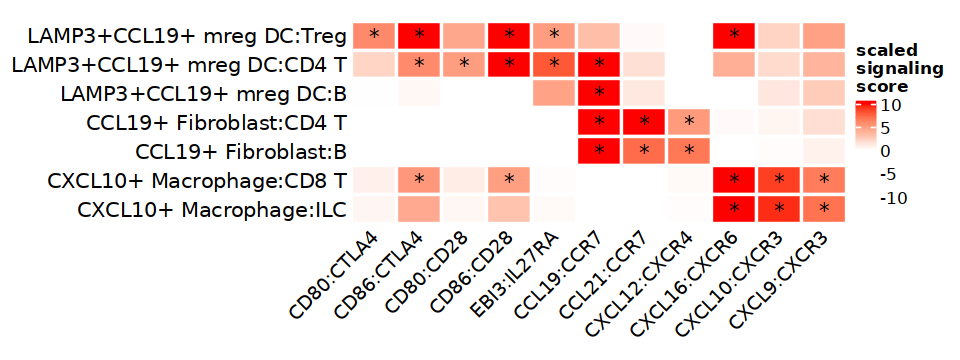

In [460]:
fig.size(3, 8)
plt = Heatmap(
    .X, 
    # t(scale(t(X))), 
    # X[which(rowSums(X == 0) < ncol(X)), ] %>% t %>% scale %>% t, 
    name = 'scaled\nsignaling\nscore', 
    row_names_side = 'left', 
    rect_gp = gpar(col = "white", lwd = 2), 
    column_names_rot = 45,
    column_names_gp = grid::gpar(fontsize = 11),
    row_names_gp = grid::gpar(fontsize = 12),
    use_raster = TRUE,
    # show_column_dend = FALSE, ## cluster receivers but don't show tree 
    # column_order = order(apply(.X, 2, which.max)), ## block diagonal order
    cluster_columns = FALSE, ## Do not cluster receivers
    cluster_rows = FALSE, ## Do not cluster senders 
    col = colorRamp2(c(-10, 0, 10), c('white', 'white', 'red')),
    # col = colorRamp2(c(-quantile(df$zempirical, .99), 0, quantile(df$zempirical, .99)), c('white', 'white', 'red')),
    # col = colorRamp2(c(-3, 0, 3), c('blue', 'white', 'red'))
    cell_fun = function(j, i, x, y, w, h, col) { # add text to each grid
        grid.text(mat_text[i, j], x, y)
    }
)

plt = grid.grabExpr(
    draw(
        plt, 
        padding = unit(c(2, 10, 2, 4), "mm"), #bottom, left, top, right paddings
    )    
) 
plt = wrap_elements(plt)
plt    


In [472]:
df[receptor == 'CCR4'][order(pval)]

sender,receiver,pathway,score,pval,ligand,receptor,zempirical,lr,pair,zscore_coloc,pval_coloc,fdr_coloc,score2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
LAMP3+CCL19+ mreg DC,Treg,CCL,3.204499e-03,0.01686235,CCL22,CCR4,4.47304794,CCL22:CCR4,LAMP3+CCL19+ mreg DC:Treg,12.46413863,5.856527e-36,5.256819e-32,4.4730479
LAMP3+CCL19+ mreg DC,Treg,CCL,3.048666e-03,0.01688208,CCL17,CCR4,4.24374420,CCL17:CCR4,LAMP3+CCL19+ mreg DC:Treg,12.46413863,5.856527e-36,5.256819e-32,4.2437442
LAMP3+CCL19+ mreg DC,CD4 T,CCL,1.843115e-03,0.03508047,CCL22,CCR4,3.34095419,CCL22:CCR4,LAMP3+CCL19+ mreg DC:CD4 T,10.96636386,2.772901e-28,2.488956e-24,3.3409542
LAMP3+CCL19+ mreg DC,CD4 T,CCL,1.101172e-03,0.03561858,CCL17,CCR4,1.89736169,CCL17:CCR4,LAMP3+CCL19+ mreg DC:CD4 T,10.96636386,2.772901e-28,2.488956e-24,1.8973617
LAMP3+CCL19+ mreg DC,CD8 T,CCL,6.715905e-04,0.14269175,CCL22,CCR4,1.34264565,CCL22:CCR4,LAMP3+CCL19+ mreg DC:CD8 T,1.52697438,6.338369e-02,1.000000e+00,0.0000000
LAMP3+CCL19+ mreg DC,CD8 T,CCL,6.483397e-04,0.15754435,CCL17,CCR4,1.28654476,CCL17:CCR4,LAMP3+CCL19+ mreg DC:CD8 T,1.52697438,6.338369e-02,1.000000e+00,0.0000000
CXCL10+ Macrophage,Treg,CCL,1.985927e-04,0.26069712,CCL17,CCR4,0.04920871,CCL17:CCR4,CXCL10+ Macrophage:Treg,3.49136786,2.402771e-04,1.000000e+00,0.0000000
LAMP3+CCL19+ mreg DC,ILC,CCL,5.541866e-04,0.26090488,CCL22,CCR4,1.23914731,CCL22:CCR4,LAMP3+CCL19+ mreg DC:ILC,-2.49525317,9.937066e-01,1.000000e+00,0.0000000
LAMP3+CCL19+ mreg DC,ILC,CCL,5.086771e-04,0.26341296,CCL17,CCR4,1.11363702,CCL17:CCR4,LAMP3+CCL19+ mreg DC:ILC,-2.49525317,9.937066e-01,1.000000e+00,0.0000000


How do present the results in a way that makes sense? 

- The p values give us no dynamic range 
- Scores are not clearly interpretable


Let's take an empirical approach. Assume that all the interactions between a sender and receiver form a null distribution of scores. Under this assumption, we derive empirical z-scores for each pair of cell types. 

The empirical z-score thing does not work. It removes too many pairs that are significant under permutation. For instance, CCR4 in Tregs. You can use the empirical z-scores for signal strength but significance comes from the permutation-based p values. 

